# Main Manuscript Analysis

This notebook also includes an analysis of a larger 3T sample in order to validate whether the results that we see in the 7T appear as we increase the sample size of the 3T

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import random
from scipy.ndimage import gaussian_filter
from scipy import stats

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE, family='Arial')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


def zero_nan(img):
    img[np.isnan(img)] = 0
    return img


def sample(data):
    sample = [random.choice(data) for _ in range(len(data))]
    return sample

def bootstrap_t_test(x1,x2, nboot=1000, direction='both'):

    # this is really a permuted t-test

    t = np.mean(x1)-np.mean(x2)

    n1 = len(x1)
    n2 = len(x2)

    group = np.hstack([x1,x2])
    group_mean = np.mean(group)
    mu1 = np.mean(x1)
    mu2 = np.mean(x2)

    idx = np.arange((n1+n2))

    t_boot_list = []
    for i in range(nboot):
        np.random.shuffle(idx)
        samp1 = group[idx[:n1]]
        samp2 = group[idx[n1:]]
        t_boot = np.mean(samp1) - np.mean(samp2)
        t_boot_list.append(t_boot)

    if direction=='both':
        p_val = (np.sum(np.array(t_boot_list)<=-np.abs(t)) + np.sum(np.array(t_boot_list)>=np.abs(t))+1)/(nboot+1)
    elif direction=='less':
        p_val = (np.sum(np.array(t_boot_list)<=(t))+1)/(nboot+1)
    elif direction=='greater':
        p_val = (np.sum(np.array(t_boot_list)>=(t))+1)/(nboot+1)

    return p_val


## Load and Harmonize the 7T data

Loads the left hippocampal and right hippocampal seed maps

In [2]:

source_data='../../source_data/seed_based_analysis/'
info_7t = pd.read_excel('../../source_data/7T_MRI_Subjects.xlsx')
brain_mask = nib.load('../../source_data/tpl-MNI152NLin2009aAsym_res-1_desc-brain_mask_resliced.nii.gz').get_fdata()

files = os.listdir(source_data)
files.remove('.DS_Store')

left_seed = []
right_seed = []
subjects = []
for i in range(len(files)):
    try:
        l = (nib.load(source_data+files[i]+'/HarvardOxford/seed_map_lh_HarvardOxford.nii.gz').get_fdata()*brain_mask)[:,:,:,np.newaxis]
        r = (nib.load(source_data+files[i]+'/HarvardOxford/seed_map_rh_HarvardOxford.nii.gz').get_fdata()*brain_mask)[:,:,:,np.newaxis]
        affine = nib.load(source_data+files[i]+'/HarvardOxford/seed_map_rh_HarvardOxford.nii.gz').affine
        left_seed.append(l)
        right_seed.append(r)
        subjects.append(files[i])
    except:
        continue

fig_outpath = '../../output/figures/figures_2023'

In [3]:
df_seed = pd.DataFrame()
df_seed['Record ID']=subjects
df_seed['LH Seed'] = left_seed
df_seed['RH Seed'] = right_seed

In [4]:
df_seed = pd.merge(df_seed, info_7t, on='Record ID')
df_seed = df_seed[df_seed['Subject Type']!='Control']

Harmonize the 7T Data

In [5]:
from neuroCombat import neuroCombat
version = df_seed['version'].values
covariate = df_seed['Lateralization'].astype('category').cat.codes.values

X = []
for i in range(len(df_seed)):
    X.append(np.concatenate((df_seed.iloc[i]['LH Seed'].ravel(),df_seed.iloc[i]['RH Seed'].ravel())))
    #X.append((df_seed.iloc[i]['RH Seed'].ravel()))


X = np.vstack(X).T

X[np.isnan(X)] = 0.01 # combat does not like zeros for some reason so inf values are replaced by very small values

covars = {'batch':version, 'type':covariate} 
covars = pd.DataFrame(covars)  

# To specify names of the variables that are categorical:
categorical_cols = ['type']

# To specify the name of the variable that encodes for the scanner/batch covariate:
batch_col = 'batch'

#Harmonization step:
data_combat = neuroCombat(dat=X,
    covars=covars,
    batch_col=batch_col, categorical_cols=categorical_cols)["data"]

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments


/Users/allucas/opt/anaconda3/envs/3t_7t/lib/python3.8/site-packages/neuroCombat/neuroCombat.py:324: RuntimeWarning: divide by zero encountered in divide
  change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())


[neuroCombat] Final adjustment of data


In [6]:
# reshape harmonized data back to normal

x,y,z,_ = df_seed.iloc[i]['LH Seed'].shape

left_harm = []
right_harm = []
for i in range(data_combat.shape[1]):
    left_harm.append(data_combat[:x*y*z,i].reshape(x,y,z,1))

    right_harm.append(data_combat[x*y*z:,i].reshape(x,y,z,1))

df_seed['LH Seed harm'] = left_harm
df_seed['RH Seed harm'] = right_harm

In [7]:
print('7T subjects: ', len(df_seed))

7T subjects:  48


## Load and Harmonize the 3T Data

Loads the left hippocampal and right hippocampal seed maps

In [8]:
source_data='../../source_data/seed_based_analysis_3t/'
info_3t = pd.read_excel('../../source_data/noddi_demo_surgical_outcomes_updated.xlsx')

protocols_3t = pd.read_csv('../../source_data/scanning_params_eli_3t.csv')

files = os.listdir(source_data)
#files.remove('.DS_Store')

left_seed_3t = []
right_seed_3t = []
subjects_3t = []

for i in range(len(files)):
    try:
        l = (nib.load(source_data+files[i]+'/HarvardOxford/seed_map_lh_HarvardOxford.nii.gz').get_fdata()*brain_mask)[:,:,:,np.newaxis]
        r = (nib.load(source_data+files[i]+'/HarvardOxford/seed_map_rh_HarvardOxford.nii.gz').get_fdata()*brain_mask)[:,:,:,np.newaxis]
        affine = nib.load(source_data+files[i]+'/HarvardOxford/seed_map_rh_HarvardOxford.nii.gz').affine
        left_seed_3t.append(l)
        right_seed_3t.append(r)
        subjects_3t.append(files[i])
    except:
        continue

fig_outpath = '../../output/figures/'

In [9]:
df_seed_3t = pd.DataFrame()
df_seed_3t['LH Seed 3t'] = left_seed_3t
df_seed_3t['RH Seed 3t'] = right_seed_3t
df_seed_3t['Subject'] = subjects_3t
df_seed_3t['Record ID'] = subjects_3t
df_seed_3t = pd.merge(info_3t,df_seed_3t, on='Subject')
df_seed_3t = pd.merge(protocols_3t, df_seed_3t, on='Subject')
# df_seed_3t = df_seed_3t[(df_seed_3t['Group']=='Control')|(df_seed_3t['7T']=='Yes')]
#df_seed_3t = df_seed_3t[(df_seed_3t['7T']=='Yes')]

Harmonize the 3T Data

In [10]:
from neuroCombat import neuroCombat
version = (df_seed_3t['protocol_number'].values>1).astype(int)
covariate = df_seed_3t['Final_Lat'].astype('category').cat.codes.values

X = []
for i in range(len(df_seed_3t)):
    X.append(np.concatenate((df_seed_3t.iloc[i]['LH Seed 3t'].ravel(),df_seed_3t.iloc[i]['RH Seed 3t'].ravel())))
    #X.append((df_seed_3t.iloc[i]['LH Seed 3t'].ravel()[int(0.4e6):int(0.41e6)]))

X = np.vstack(X).T

X[np.isnan(X)] = 0.01

covars = {'batch':version, 'type':covariate} 
covars = pd.DataFrame(covars)  

# To specify names of the variables that are categorical:
categorical_cols = ['type']

# To specify the name of the variable that encodes for the scanner/batch covariate:
batch_col = 'batch'

#Harmonization step:
data_combat = neuroCombat(dat=X,
    covars=covars,
    batch_col=batch_col, categorical_cols=categorical_cols)["data"]

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments


/Users/allucas/opt/anaconda3/envs/3t_7t/lib/python3.8/site-packages/neuroCombat/neuroCombat.py:324: RuntimeWarning: divide by zero encountered in divide
  change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())


[neuroCombat] Final adjustment of data


In [11]:
# reshape harmonized data back to normal

x,y,z,_ = df_seed_3t.iloc[0]['LH Seed 3t'].shape

left_harm = []
right_harm = []
for i in range(data_combat.shape[1]):
    left_harm.append(data_combat[:x*y*z,i].reshape(x,y,z,1))

    right_harm.append(data_combat[x*y*z:,i].reshape(x,y,z,1))

df_seed_3t['LH Seed 3t harm'] = left_harm
df_seed_3t['RH Seed 3t harm'] = right_harm

In [12]:
print('Number of 3T subjects included for harmonization:', len(df_seed_3t))

Number of 3T subjects included for harmonization: 116


## Combining 3T and 7T Data

We use Pandas in order to merge the seedmaps from 3T with the seedmaps from 7T into the same dataframe

Merge the 3T and 7T Data

In [13]:
df_seed_all = pd.merge(df_seed_3t, df_seed, on='Record ID')
df_seed_all = df_seed_all[df_seed_all['Final_Loc']=='Temporal']

In [14]:
print('Number of paired 3T-7T subjects included: ', len(df_seed_all[df_seed_all['Lateralization']=='Left']) + len(df_seed_all[df_seed_all['Lateralization']=='Right']))

Number of paired 3T-7T subjects included:  19


Check for any NaNs in the harmonized seed maps

In [15]:
for i in range(len(df_seed_all)):
    print(df_seed_all['Record ID'].iloc[i])
    print('7T R-Seed has any nans:',np.isnan(df_seed_all['RH Seed harm'].iloc[i]).any())
    print('7T L-Seed has any nans:',np.isnan(df_seed_all['LH Seed harm'].iloc[i]).any())

    print('3T R-Seed has any nans:',np.isnan(df_seed_all['RH Seed 3t harm'].iloc[i]).any())
    print('3T L-Seed has any nans:',np.isnan(df_seed_all['LH Seed 3t harm'].iloc[i]).any())

sub-RID0420
7T R-Seed has any nans: False
7T L-Seed has any nans: False
3T R-Seed has any nans: False
3T L-Seed has any nans: False
sub-RID0365
7T R-Seed has any nans: False
7T L-Seed has any nans: False
3T R-Seed has any nans: False
3T L-Seed has any nans: False
sub-RID0448
7T R-Seed has any nans: False
7T L-Seed has any nans: False
3T R-Seed has any nans: False
3T L-Seed has any nans: False
sub-RID0121
7T R-Seed has any nans: False
7T L-Seed has any nans: False
3T R-Seed has any nans: False
3T L-Seed has any nans: False
sub-RID0455
7T R-Seed has any nans: False
7T L-Seed has any nans: False
3T R-Seed has any nans: False
3T L-Seed has any nans: False
sub-RID0490
7T R-Seed has any nans: False
7T L-Seed has any nans: False
3T R-Seed has any nans: False
3T L-Seed has any nans: False
sub-RID0508
7T R-Seed has any nans: False
7T L-Seed has any nans: False
3T R-Seed has any nans: False
3T L-Seed has any nans: False
sub-RID0522
7T R-Seed has any nans: False
7T L-Seed has any nans: False
3T R

Save the protocol info for the subjects into an excel sheet

In [16]:
df_protocol_info = df_seed_all[['rid','protocol_number','version']]
df_protocol_info.columns = ['RID','3T Protocol','7T Protocol']
#df_protocol_info.to_excel('/Users/allucas/Documents/research/CNT/P18_7T_rsfMRI/source_data/subjects_3t_7t_protocols.xlsx')

In [17]:
df_seed_all.columns

Index(['rid', 'Subject', 'protocol_full', 'protocol_number', 'TR', 'TE',
       'flip_angle', 'FOV', 'Matrix', 'Slices', 'vox_size', 'MB',
       'echo_spacing', 'BW', 'scanner', 'ctrl', 'IEEG', 'Sex', 'SzOnset',
       'BTCS', 'FIAS', 'FAS', 'PNEE', 'Etiology', 'Subtype', 'MRI_Lesional',
       'MRI_Lesion_Lat', 'MRI_Lesion_Loc', 'Final_Lat', 'Final_Loc', 'Control',
       'Surgical_Outcome_Engel_num', 'Surgical_Outcome_Engel_letter',
       'Surgical_Outcome_all', 'Device', 'Group', '7T', 'Lesional_PET',
       'Location_PET', 'Lateralization_PET', 'LH Seed 3t', 'RH Seed 3t',
       'Record ID', 'LH Seed 3t harm', 'RH Seed 3t harm', 'LH Seed', 'RH Seed',
       'RID NUMBER', '7T Subject ID', 'version', 'Patient Last Name',
       'Patient First Name', 'MRN', 'Date of Birth', 'Date of first scan',
       'Age', 'Subject Type',
       'Seizure type at onset (It is a mix of old and new terminology)',
       'Type_Final', 'Type (MTL/NE/Other)', 'MTS (y/n)', 'Lateralization',
       'Enge

In [18]:
#df_seed_all[['Subject','Sex','Final_Loc','Lateralization', 'MTS (y/n)', 'MRI_Lesion_Loc','MRI_Lesional','Surgical_Outcome_all', 'protocol_number','version']].to_excel('/Users/allucas/Documents/research/CNT/P18_7T_rsfMRI/source_data/subjects_3t_7t_subject_info.xlsx')

## Voxelwise Cohen's D Maps and basic analyses of them

After generating a dataframe that has seed maps harmonized across protocols, as well as data from the 3T and 7T subjects, we can perform careful statistical analyses

In [182]:
# save nifities throughout the analysis

save = False

In [183]:
left_seeds_all_7t = np.concatenate(df_seed_all['LH Seed harm'].values,axis=3)
right_seeds_all_7t = np.concatenate(df_seed_all['RH Seed harm'].values,axis=3)

left_seeds_all_3t = np.concatenate(df_seed_all['LH Seed 3t harm'].values,axis=3) 
right_seeds_all_3t = np.concatenate(df_seed_all['RH Seed 3t harm'].values,axis=3)

In [184]:
from scipy import stats
from tqdm import tqdm

def get_voxelwise_ttest(group1, group2):
    ttest_map, p_map = stats.ttest_ind(group1, group2, axis=3)
    return ttest_map

from scipy.ndimage import gaussian_filter

def save_nifti(np_img, affine, fname):
    outdir = '../../output/cohensd_maps_2023/'
    nifti = nib.Nifti1Image(np_img,affine)
    nib.save(nifti, outdir+fname)


In [185]:
# lat = 'Left'
# tmap_7t,p_7t = stats.ttest_1samp(left_seeds_all_7t[:,:,:,df_seed_all['Lateralization']==lat]-right_seeds_all_7t[:,:,:,df_seed_all['Lateralization']==lat],popmean=0,axis=3)
# tmap_3t,p_3t = stats.ttest_1samp(left_seeds_all_3t[:,:,:,df_seed_all['Lateralization']==lat]-right_seeds_all_3t[:,:,:,df_seed_all['Lateralization']==lat],popmean=0,axis=3)



In [186]:

# save_nifti(gaussian_filter(zero_nan(tmap_3t),sigma=0.5), affine,'tmap_3t_'+lat+'_tle.nii.gz')
# save_nifti(gaussian_filter(zero_nan(tmap_7t),sigma=0.5), affine,'tmap_7t_'+lat+'_tle.nii.gz')


# save_nifti(gaussian_filter(1-p_3t,sigma=0.5), affine,'pmap_3t_'+lat+'_tle.nii.gz')
# save_nifti(gaussian_filter(1-p_7t,sigma=0.5), affine,'pmap_7t_'+lat+'_tle.nii.gz')

### Generating Voxelwise Cohen's D Maps

Generating voxelwise Cohen's D maps at the group level

In [25]:
def cohend_voxelwise(d1, d2):
	# calculate the size of samples
	n1, n2 = d1.shape[-1], d2.shape[-1]
	# calculate the variance of the samples
	s1, s2 = np.nanvar(d1, ddof=1,axis=3), np.nanvar(d2, ddof=1,axis=3)
	# calculate the pooled standard deviation
	s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = np.nanmean(d1,axis=3), np.nanmean(d2,axis=3)
	# calculate the effect size
	return (u1 - u2) / s

In [26]:
brain_mask = nib.load('../../source_data/tpl-MNI152NLin2009aAsym_res-1_desc-brain_mask_resliced.nii.gz').get_fdata()
brain_mask[brain_mask==0] = np.nan
lat = 'Left'

cohend_vox_7t = cohend_voxelwise(left_seeds_all_7t[:,:,:,df_seed_all['Lateralization']==lat],right_seeds_all_7t[:,:,:,df_seed_all['Lateralization']==lat])
cohend_vox_3t = cohend_voxelwise(left_seeds_all_3t[:,:,:,df_seed_all['Lateralization']==lat],right_seeds_all_3t[:,:,:,df_seed_all['Lateralization']==lat])

if save == True:
    save_nifti(gaussian_filter(cohend_vox_7t,sigma=0.5)*brain_mask, affine,'cohend_7t_'+lat+'_tle2.nii.gz')
    save_nifti(gaussian_filter(cohend_vox_3t,sigma=0.5)*brain_mask, affine,'cohend_3t_'+lat+'_tle2.nii.gz')

    # Save very smoothed maps
    save_nifti(gaussian_filter(zero_nan(cohend_vox_7t),sigma=2)*brain_mask, affine,'cohend_7t_'+lat+'_tle_smoothed2.nii.gz')
    save_nifti(gaussian_filter(zero_nan(cohend_vox_3t),sigma=2)*brain_mask, affine,'cohend_3t_'+lat+'_tle_smoothed2.nii.gz')


lat = 'Right'

cohend_vox_7t = cohend_voxelwise(left_seeds_all_7t[:,:,:,df_seed_all['Lateralization']==lat],right_seeds_all_7t[:,:,:,df_seed_all['Lateralization']==lat])
cohend_vox_3t = cohend_voxelwise(left_seeds_all_3t[:,:,:,df_seed_all['Lateralization']==lat],right_seeds_all_3t[:,:,:,df_seed_all['Lateralization']==lat])

if save == True:
    save_nifti(gaussian_filter(cohend_vox_7t,sigma=0.5)*brain_mask, affine,'cohend_7t_'+lat+'_tle2.nii.gz')
    save_nifti(gaussian_filter(cohend_vox_3t,sigma=0.5)*brain_mask, affine,'cohend_3t_'+lat+'_tle2.nii.gz')

    # Save very smoothed maps
    save_nifti(gaussian_filter(zero_nan(cohend_vox_7t),sigma=2)*brain_mask, affine,'cohend_7t_'+lat+'_tle_smoothed2.nii.gz')
    save_nifti(gaussian_filter(zero_nan(cohend_vox_3t),sigma=2)*brain_mask, affine,'cohend_3t_'+lat+'_tle_smoothed2.nii.gz')


### Measure the Cohen's D in the PCC

In [27]:
HO = nib.load('../../../P4_high_freq_fmri/xcpEngine_atlases/atlas/HarvardOxford/HarvardOxfordMNI.nii').get_fdata()

In [28]:
left_pcc = (HO==300).astype(float)
left_pcc[left_pcc==0] = np.nan

right_pcc = (HO==301).astype(float)
right_pcc[right_pcc==0] = np.nan

In [29]:
dist_7t = (left_pcc*cohend_vox_7t).ravel()
dist_3t = (left_pcc*cohend_vox_3t).ravel()

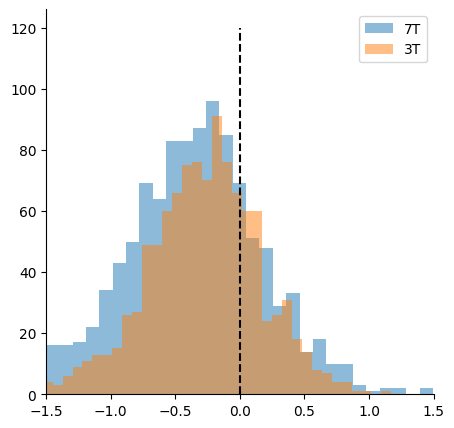

In [30]:
plt.figure(figsize=(5,5))
plt.hist(dist_7t, alpha=0.5,bins=40)
plt.hist(dist_3t,alpha=0.5, bins=40)
plt.legend(['7T','3T'])
plt.xlim([-1.5,1.5])
plt.vlines(x=0, ymin=0, ymax=120, color='k', linestyle='--')
sns.despine()

In [31]:
def drop_na(arr):
    arr = arr[~np.isnan(arr)]
    return arr
stats.ttest_ind(drop_na(dist_3t), drop_na(dist_7t))

Ttest_indResult(statistic=2.933380324741276, pvalue=0.0033885082993067193)

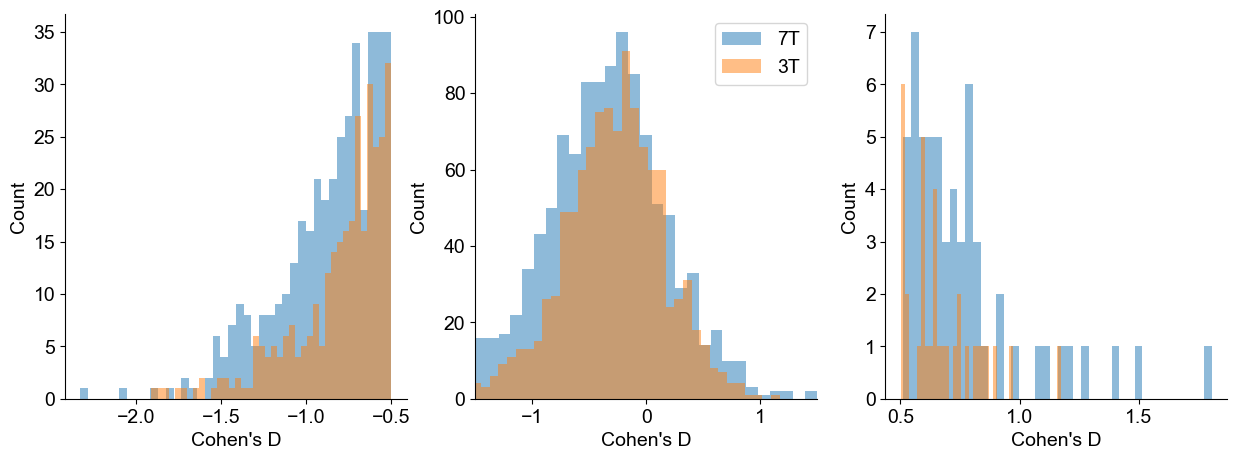

In [32]:
# Plotting Parameters
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE, family='Arial')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


plt.figure(figsize=(15,5))
plt.subplot(131)
#plt.figure(figsize=(5,5))
plt.hist(dist_7t[dist_7t<-0.5], alpha=0.5,bins=40)
plt.hist(dist_3t[dist_3t<-0.5],alpha=0.5, bins=40)
plt.ylabel('Count')
plt.xlabel('Cohen\'s D')
#plt.legend(['7T','3T'])
#plt.xlim([-1.5,1.5])
#plt.vlines(x=0, ymin=0, ymax=120, color='k', linestyle='--')
sns.despine()

plt.subplot(132)
plt.hist(dist_7t, alpha=0.5,bins=40)
plt.hist(dist_3t,alpha=0.5, bins=40)
plt.legend(['7T','3T'])
plt.xlim([-1.5,1.5])
plt.ylabel('Count')
plt.xlabel('Cohen\'s D')

#plt.vlines(x=0, ymin=0, ymax=120, color='k', linestyle='--')
sns.despine()

plt.subplot(133)
#plt.figure(figsize=(5,5))
plt.hist(dist_7t[dist_7t>0.5], alpha=0.5,bins=40)
plt.hist(dist_3t[dist_3t>0.5],alpha=0.5, bins=40)
#plt.legend(['7T','3T'])
#plt.xlim([-1.5,1.5])
#plt.vlines(x=0, ymin=0, ymax=120, color='k', linestyle='--')
plt.ylabel('Count')
plt.xlabel('Cohen\'s D')
sns.despine()

Chi-Squared test on the number of voxels with a moderate effect size in each group

In [33]:
a = np.nansum(dist_7t>0.5)
b = np.nansum(dist_3t>0.5)
c = np.nansum(dist_7t<-0.5)
d = np.nansum(dist_3t<-0.5)

In [34]:
obs = np.array([[a,b], [c,d]])
chi,p,dof,count = stats.chi2_contingency(obs)
print('Chi2 p-value: ', p)

Chi2 p-value:  0.2500049780099587


### Get Permuted Values of the Difference in Mean Cohen's D between left and right PCC and MPFC

Functions to load the PCC and MPFC masks as well for computing the permutations

In [35]:
# Define the DMN mask
sch = nib.load('../../source_data/modified_atlases/schaefer200x7_resliced_7T_fmri.nii').get_fdata()
communities = np.loadtxt('../../source_data/modified_atlases/schaefer200x7CommunityAffiliation.1D')

dmn_mask_left = np.zeros(sch.shape)
dmn_mask_right = np.zeros(sch.shape)


for i in range(len(communities)//2):
    if communities[i]==7:
        dmn_mask_left[sch==i+1] = 1 

for i in range(len(communities)//2):
    if communities[i+100]==7:
        dmn_mask_right[sch==i+100+1] = 1 

# Define the PCC
left_pcc = ((HO==300).astype(float) + (HO==310).astype(float))*dmn_mask_left
left_pcc[left_pcc==0] = np.nan

right_pcc = ((HO==301).astype(float)+ (HO==311).astype(float))*dmn_mask_right
right_pcc[right_pcc==0] = np.nan

# Define the MPFC
left_fp = (HO==10).astype(float) + (HO==30).astype(float)
left_fp[left_fp==0] = np.nan

right_fp = (HO==11).astype(float) + (HO==31).astype(float)
right_fp[right_fp==0] = np.nan

left_mdfc = dmn_mask_left*left_fp
right_mdfc = dmn_mask_right*right_fp


brain_mask = nib.load('../../source_data/tpl-MNI152NLin2009aAsym_res-1_desc-brain_mask_resliced.nii.gz').get_fdata()
brain_mask[brain_mask==0] = np.nan
lat = 'Left'


pcc_all = ((HO==300).astype(float) + (HO==310).astype(float))*dmn_mask_left + ((HO==301).astype(float)+ (HO==311).astype(float))*dmn_mask_right
pcc_all[pcc_all>0] = 1
pcc_all[pcc_all==0] = np.nan

mdfc_all = zero_nan((dmn_mask_left*left_fp).astype(float)) + zero_nan((dmn_mask_right*right_fp).astype(float))
mdfc_all[mdfc_all>0] = 1
mdfc_all[mdfc_all==0] = np.nan

# Functions to Compute the Permutation
def zero_nan(img):
    img[np.isnan(img)] = 0
    img[np.isinf(img)] = 0

    return img

def nan_zero(img):
    img[img==0] = np.nan
    return img


def permute_cohend_diff(df_seed_all, left_seeds_all, right_seeds_all, mask_left,mask_right,n_iters=1000):
    df_seed_all_perm = df_seed_all.copy()
    diff = []
    for i in tqdm(range(n_iters)):
        np.random.shuffle(df_seed_all_perm['Lateralization'].values)
        cohend_vox_left = cohend_voxelwise(left_seeds_all[:,:,:,df_seed_all_perm['Lateralization']=='Left'],right_seeds_all[:,:,:,df_seed_all_perm['Lateralization']=='Left'])
        
        cohend_vox_right = cohend_voxelwise(left_seeds_all[:,:,:,df_seed_all_perm['Lateralization']=='Right'],right_seeds_all[:,:,:,df_seed_all_perm['Lateralization']=='Right'])
        
        mu_left = np.nanmean(nan_zero(mask_left*cohend_vox_left))
        mu_right = np.nanmean(nan_zero(mask_right*cohend_vox_right))
        diff.append(mu_right-mu_left)
    return np.array(diff)

def get_p_value_from_perm(val, perm_dist,tail='greater'):
    if tail == 'greater':
        p = (np.sum(perm_dist>val)+1)/(len(perm_dist)+1)
    else:
        p = (np.sum(perm_dist<val)+1)/(len(perm_dist)+1)
    return p



#### 7T Permutation

  1%|          | 9/1000 [00:03<05:46,  2.86it/s]/var/folders/cd/2tvrfhlx5cnbjft2fv0kn5gr0000gn/T/ipykernel_52178/3764278483.py:11: RuntimeWarning: invalid value encountered in divide
  return (u1 - u2) / s
100%|██████████| 1000/1000 [05:46<00:00,  2.89it/s]


p-value, PCC: 0.001998001998001998


100%|██████████| 1000/1000 [05:42<00:00,  2.92it/s]

p-value, MPFC: 0.011988011988011988


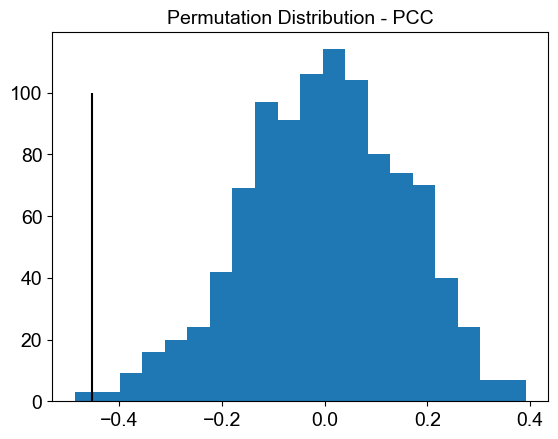

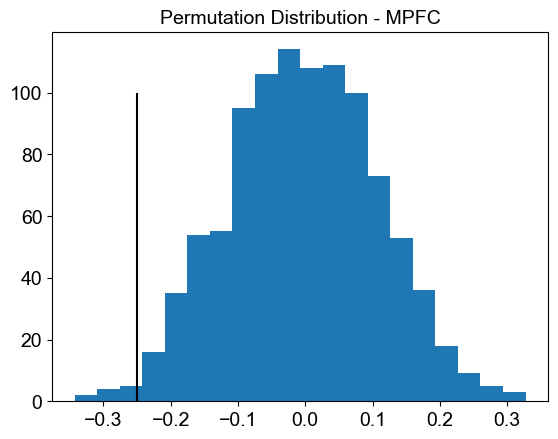

In [38]:
# Get the actual difference
right_tle_7t = nib.load('../../output/cohensd_maps_2023/cohend_7t_Right_tle2.nii.gz').get_fdata()
left_tle_7t = nib.load('../../output/cohensd_maps_2023/cohend_7t_Left_tle2.nii.gz').get_fdata()

# PCC Distribution
dist_7t_left = (left_pcc*left_tle_7t).ravel()
dist_7t_right = (right_pcc*right_tle_7t).ravel()

# MPFC Distribution
dist_7t_left_mpfc = (left_mdfc*left_tle_7t).ravel()
dist_7t_right_mpfc = (right_mdfc*right_tle_7t).ravel()


# PCC
diff_7t = permute_cohend_diff(df_seed_all, left_seeds_all_7t, right_seeds_all_7t, mask_left=pcc_all, mask_right=pcc_all)
print('p-value, PCC:',get_p_value_from_perm(np.nanmean(nan_zero(dist_7t_right))-np.nanmean(nan_zero(dist_7t_left)), np.array(diff_7t),'less'))
plt.hist(diff_7t,20)
plt.title('Permutation Distribution - PCC')
plt.vlines(ymin=0, ymax=100, x=np.nanmean(dist_7t_right)-np.nanmean(dist_7t_left), color='k')

# MPFC
diff_7t_mpfc = permute_cohend_diff(df_seed_all, left_seeds_all_7t, right_seeds_all_7t, mask_left=mdfc_all, mask_right=mdfc_all)
print('p-value, MPFC:',get_p_value_from_perm(np.nanmean(nan_zero(dist_7t_right_mpfc))-np.nanmean(nan_zero(dist_7t_left_mpfc)), np.array(diff_7t_mpfc),'less'))
plt.figure()
plt.hist(diff_7t_mpfc,20)
plt.title('Permutation Distribution - MPFC')
plt.vlines(ymin=0, ymax=100, x=np.nanmean(nan_zero(dist_7t_right_mpfc))-np.nanmean(nan_zero(dist_7t_left_mpfc)), color='k')



#### 3T Permutation

  6%|▌         | 62/1000 [00:21<05:23,  2.90it/s]/var/folders/cd/2tvrfhlx5cnbjft2fv0kn5gr0000gn/T/ipykernel_52178/3764278483.py:11: RuntimeWarning: invalid value encountered in divide
  return (u1 - u2) / s
 70%|███████   | 701/1000 [04:01<01:43,  2.88it/s]/var/folders/cd/2tvrfhlx5cnbjft2fv0kn5gr0000gn/T/ipykernel_52178/3764278483.py:11: RuntimeWarning: divide by zero encountered in divide
  return (u1 - u2) / s
100%|██████████| 1000/1000 [05:44<00:00,  2.90it/s]


p-value, PCC: 0.1798201798201798


100%|██████████| 1000/1000 [05:40<00:00,  2.94it/s]

p-value, MPFC: 0.03696303696303696


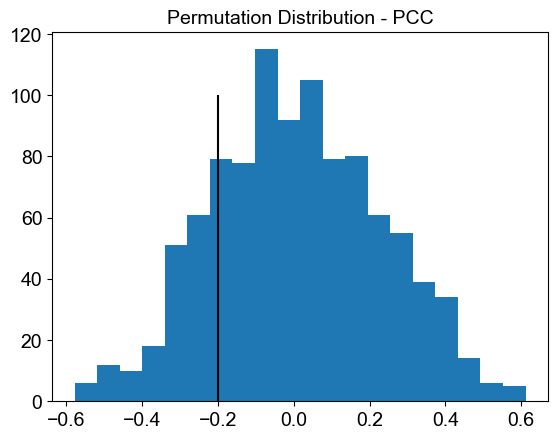

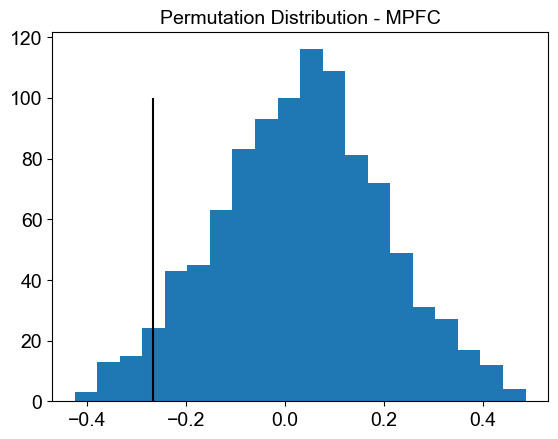

In [42]:
# Get the actual difference
right_tle_3t = nib.load('../../output/cohensd_maps_2023/cohend_3t_Right_tle2.nii.gz').get_fdata()
left_tle_3t = nib.load('../../output/cohensd_maps_2023/cohend_3t_Left_tle2.nii.gz').get_fdata()

# PCC Distribution
dist_3t_left = (left_pcc*left_tle_3t).ravel()
dist_3t_right = (right_pcc*right_tle_3t).ravel()

# MPFC Distribution
dist_3t_left_mpfc = (left_mdfc*left_tle_3t).ravel()
dist_3t_right_mpfc = (right_mdfc*right_tle_3t).ravel()


# PCC
diff_3t = permute_cohend_diff(df_seed_all, left_seeds_all_3t, right_seeds_all_3t, mask_left=left_pcc, mask_right=pcc_all)
print('p-value, PCC:',get_p_value_from_perm(np.nanmean(nan_zero(dist_3t_right))-np.nanmean(nan_zero(dist_3t_left)), np.array(diff_3t),'less'))
plt.hist(diff_3t,20)
plt.title('Permutation Distribution - PCC')
plt.vlines(ymin=0, ymax=100, x=np.nanmean(dist_3t_right)-np.nanmean(dist_3t_left), color='k')

# MPFC
diff_3t_mpfc = permute_cohend_diff(df_seed_all, left_seeds_all_3t, right_seeds_all_3t, mask_left=left_mdfc, mask_right=mdfc_all)
print('p-value, MPFC:',get_p_value_from_perm(np.nanmean(nan_zero(dist_3t_right_mpfc))-np.nanmean(nan_zero(dist_3t_left_mpfc)), np.array(diff_3t_mpfc),'less'))
plt.figure()
plt.hist(diff_3t_mpfc,20)
plt.title('Permutation Distribution - MPFC')
plt.vlines(ymin=0, ymax=100, x=np.nanmean(nan_zero(dist_3t_right_mpfc))-np.nanmean(nan_zero(dist_3t_left_mpfc)), color='k')





#### 3T Extended - Permutation

  0%|          | 5/1000 [00:01<05:39,  2.93it/s]/var/folders/cd/2tvrfhlx5cnbjft2fv0kn5gr0000gn/T/ipykernel_52178/3764278483.py:11: RuntimeWarning: invalid value encountered in divide
  return (u1 - u2) / s
100%|██████████| 1000/1000 [05:41<00:00,  2.93it/s]


p-value, PCC: 0.08791208791208792


100%|██████████| 1000/1000 [05:40<00:00,  2.93it/s]

p-value, MPFC: 0.07892107892107893


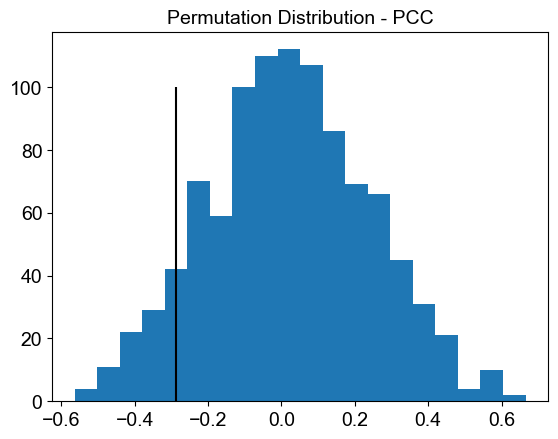

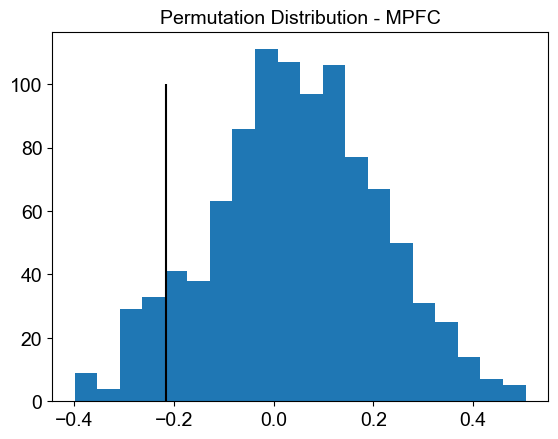

In [46]:
# Get the actual difference
right_tle_3t = nib.load('../../output/cohend_3t_all_R_tle.nii.gz').get_fdata()
left_tle_3t = nib.load('../../output/cohend_3t_all_L_tle.nii.gz').get_fdata()

# PCC Distribution
dist_3t_left = (left_pcc*left_tle_3t).ravel()
dist_3t_right = (right_pcc*right_tle_3t).ravel()

# MPFC Distribution
dist_3t_left_mpfc = (left_mdfc*left_tle_3t).ravel()
dist_3t_right_mpfc = (right_mdfc*right_tle_3t).ravel()


# PCC
diff_3t = permute_cohend_diff(df_seed_all, left_seeds_all_3t, right_seeds_all_3t, mask_left=left_pcc, mask_right=pcc_all)
print('p-value, PCC:',get_p_value_from_perm(np.nanmean(nan_zero(dist_3t_right))-np.nanmean(nan_zero(dist_3t_left)), np.array(diff_3t),'less'))
plt.hist(diff_3t,20)
plt.title('Permutation Distribution - PCC')
plt.vlines(ymin=0, ymax=100, x=np.nanmean(dist_3t_right)-np.nanmean(dist_3t_left), color='k')

# MPFC
diff_3t_mpfc = permute_cohend_diff(df_seed_all, left_seeds_all_3t, right_seeds_all_3t, mask_left=left_mdfc, mask_right=mdfc_all)
print('p-value, MPFC:',get_p_value_from_perm(np.nanmean(nan_zero(dist_3t_right_mpfc))-np.nanmean(nan_zero(dist_3t_left_mpfc)), np.array(diff_3t_mpfc),'less'))
plt.figure()
plt.hist(diff_3t_mpfc,20)
plt.title('Permutation Distribution - MPFC')
plt.vlines(ymin=0, ymax=100, x=np.nanmean(nan_zero(dist_3t_right_mpfc))-np.nanmean(nan_zero(dist_3t_left_mpfc)), color='k')


#### 7T Extended - Permutation

  2%|▏         | 16/1000 [00:05<05:37,  2.91it/s]/var/folders/cd/2tvrfhlx5cnbjft2fv0kn5gr0000gn/T/ipykernel_52178/3764278483.py:11: RuntimeWarning: invalid value encountered in divide
  return (u1 - u2) / s
100%|██████████| 1000/1000 [05:47<00:00,  2.88it/s]


p-value, PCC: 0.012987012987012988


100%|██████████| 1000/1000 [05:44<00:00,  2.90it/s]

p-value, MPFC: 0.03796203796203796


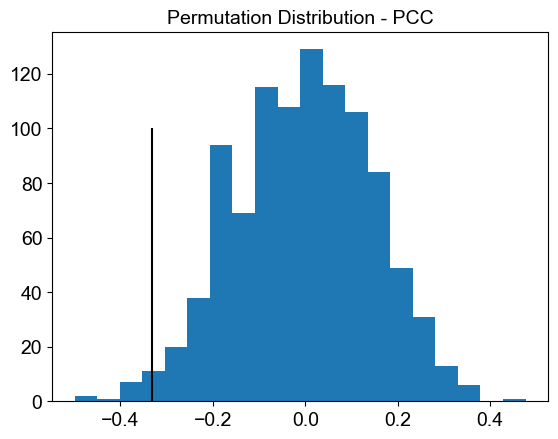

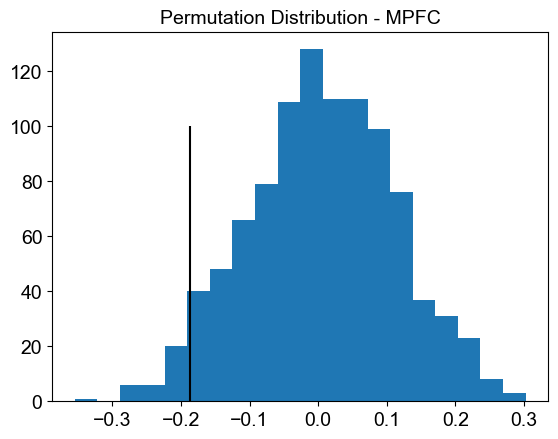

In [49]:
# Get the actual difference
right_tle_7t = nib.load('../../output/cohensd_maps_2023/cohend_7t_extended_Right_tle.nii.gz').get_fdata()
left_tle_7t = nib.load('../../output/cohensd_maps_2023/cohend_7t_extended_Left_tle.nii.gz').get_fdata()

# PCC Distribution
dist_7t_left = (left_pcc*left_tle_7t).ravel()
dist_7t_right = (right_pcc*right_tle_7t).ravel()

# MPFC Distribution
dist_7t_left_mpfc = (left_mdfc*left_tle_7t).ravel()
dist_7t_right_mpfc = (right_mdfc*right_tle_7t).ravel()


# PCC
diff_7t = permute_cohend_diff(df_seed_all, left_seeds_all_7t, right_seeds_all_7t, mask_left=pcc_all, mask_right=pcc_all)
print('p-value, PCC:',get_p_value_from_perm(np.nanmean(nan_zero(dist_7t_right))-np.nanmean(nan_zero(dist_7t_left)), np.array(diff_7t),'less'))
plt.hist(diff_7t,20)
plt.title('Permutation Distribution - PCC')
plt.vlines(ymin=0, ymax=100, x=np.nanmean(dist_7t_right)-np.nanmean(dist_7t_left), color='k')

# MPFC
diff_7t_mpfc = permute_cohend_diff(df_seed_all, left_seeds_all_7t, right_seeds_all_7t, mask_left=mdfc_all, mask_right=mdfc_all)
print('p-value, MPFC:',get_p_value_from_perm(np.nanmean(nan_zero(dist_7t_right_mpfc))-np.nanmean(nan_zero(dist_7t_left_mpfc)), np.array(diff_7t_mpfc),'less'))
plt.figure()
plt.hist(diff_7t_mpfc,20)
plt.title('Permutation Distribution - MPFC')
plt.vlines(ymin=0, ymax=100, x=np.nanmean(nan_zero(dist_7t_right_mpfc))-np.nanmean(nan_zero(dist_7t_left_mpfc)), color='k')


#### 3T All Pemutation

 To run this cell you need to run the cell below that says: Harmonize all 3T subjects -- Sorry :(

In [30]:
# To run this cell you need to run the cell below that says: Harmonize all 3T subjects -- Sorry :(

def permute_cohend_diff_3tall(df_seed_all, left_seeds_all, right_seeds_all, mask_left,mask_right,n_iters=1000):
    df_seed_all_perm = df_seed_all.copy()
    diff = []
    for i in tqdm(range(n_iters)):
        np.random.shuffle(df_seed_all_perm['Final_Lat'].values)
        cohend_vox_left = cohend_voxelwise(left_seeds_all[:,:,:,df_seed_all_perm['Final_Lat']=='L'],right_seeds_all[:,:,:,df_seed_all_perm['Final_Lat']=='L'])
        
        cohend_vox_right = cohend_voxelwise(left_seeds_all[:,:,:,df_seed_all_perm['Final_Lat']=='R'],right_seeds_all[:,:,:,df_seed_all_perm['Final_Lat']=='R'])
        
        mu_left = np.nanmean(nan_zero(mask_left*cohend_vox_left))
        mu_right = np.nanmean(nan_zero(mask_left*cohend_vox_right))
        diff.append(mu_right-mu_left)
    return np.array(diff)


# Get the actual difference
right_tle_3t_all = nib.load('/Users/allucas/Documents/research/CNT/P18_7T_rsfMRI/output/cohend_3t_all_R_tle.nii.gz').get_fdata()
left_tle_3t_all = nib.load('/Users/allucas/Documents/research/CNT/P18_7T_rsfMRI/output/cohend_3t_all_L_tle.nii.gz').get_fdata()

# PCC Distribution
dist_3t_left_all = (left_pcc*left_tle_3t_all).ravel()
dist_3t_right_all = (right_pcc*right_tle_3t_all).ravel()

# MPFC Distribution
dist_3t_left_all_mpfc = (left_mdfc*left_tle_3t_all).ravel()
dist_3t_right_all_mpfc = (right_mdfc*right_tle_3t_all).ravel()

# PCC
diff_3t_all = permute_cohend_diff_3tall(df_seed_3t, left_seeds_all_3t_all, right_seeds_all_3t_all, mask_left=left_pcc, mask_right=right_pcc)
print('p-value, PCC: ',get_p_value_from_perm(np.nanmean(dist_3t_right_all)-np.nanmean(dist_3t_left_all), np.array(diff_3t_all),'less'))
plt.hist(diff_3t_all,20)
plt.title('Permutation Distribution - PCC')
plt.vlines(ymin=0, ymax=100, x=np.nanmean(dist_3t_right_all)-np.nanmean(dist_3t_left_all), color='k')

# MPFC
diff_3t_all_mpfc = permute_cohend_diff_3tall(df_seed_3t, left_seeds_all_3t_all, right_seeds_all_3t_all, mask_left=left_mdfc, mask_right=right_mdfc)
print('p-value, MPFC:',get_p_value_from_perm(np.nanmean(nan_zero(dist_3t_right_all_mpfc))-np.nanmean(nan_zero(dist_3t_left_all_mpfc)), np.array(diff_3t_all_mpfc),'less'))
plt.figure()
plt.hist(diff_3t_mpfc,20)
plt.title('Permutation Distribution - MPFC')
plt.vlines(ymin=0, ymax=100, x=np.nanmean(nan_zero(dist_3t_right_all_mpfc))-np.nanmean(nan_zero(dist_3t_left_all_mpfc)), color='k')



FileNotFoundError: No such file or no access: '/Users/allucas/Documents/research/CNT/P18_7T_rsfMRI/output/cohend_3t_all_R_tle.nii.gz'

## Analysis of connectivity between the hippocampus and the PCC using the Seed-to-Voxel maps

This section calculates the strength of the connectivity to the PCC

In this section, the left vs. right issue is fixed. From here on, left is left, right is right

In [15]:
def cohend(d1, d2):
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = np.nanvar(d1, ddof=1), np.nanvar(d2, ddof=1)
	# calculate the pooled standard deviation
	s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = np.nanmean(d1), np.nanmean(d2)
	# calculate the effect size
	return (u1 - u2) / s

In [16]:
# left_pcc = (HO==301).astype(float)
# left_pcc[left_pcc==0] = np.nan

# right_pcc = (HO==300).astype(float)
# right_pcc[right_pcc==0] = np.nan

## Updated
HO = nib.load('../../../P4_high_freq_fmri/xcpEngine_atlases/atlas/HarvardOxford/HarvardOxfordMNI.nii').get_fdata()

# Define the DMN mask
sch = nib.load('../../source_data/modified_atlases/schaefer200x7_resliced_7T_fmri.nii').get_fdata()
communities = np.loadtxt('../../source_data/modified_atlases/schaefer200x7CommunityAffiliation.1D')

dmn_mask_left = np.zeros(sch.shape)
dmn_mask_right = np.zeros(sch.shape)


for i in range(len(communities)//2):
    if communities[i]==7:
        dmn_mask_left[sch==i+1] = 1 

for i in range(len(communities)//2):
    if communities[i+100]==7:
        dmn_mask_right[sch==i+100+1] = 1 


left_pcc = ((HO==300).astype(float) + (HO==310).astype(float))*dmn_mask_left
left_pcc[left_pcc==0] = np.nan

right_pcc = ((HO==301).astype(float)+ (HO==311).astype(float))*dmn_mask_right
right_pcc[right_pcc==0] = np.nan


pcc_all = ((HO==300).astype(float) + (HO==310).astype(float))*dmn_mask_left + ((HO==301).astype(float)+ (HO==311).astype(float))*dmn_mask_right
pcc_all[pcc_all>0] = 1
pcc_all[pcc_all==0] = np.nan

# left_pcc = ((HO==10).astype(float) + (HO==30).astype(float))*dmn_mask_left
# left_pcc[left_pcc==0] = np.nan

# right_pcc = ((HO==11).astype(float) + (HO==31).astype(float))*dmn_mask_right
# right_pcc[right_pcc==0] = np.nan

In [17]:
def get_mask_connectivity(seed_maps, mask):
    conn = []
    for i in range(seed_maps.shape[-1]):
        conn.append(np.nanmean((gaussian_filter(seed_maps[:,:,:,i],0.5))*mask))
    return np.array(conn)

# def get_mask_connectivity(seed_maps, mask):
#     conn = []
#     for i in range(seed_maps.shape[-1]):
#         conn.append(np.nanmean((gaussian_filter(zero_nan(seed_maps[:,:,:,i]),4))*mask))
#     return np.array(conn)



In [18]:
l_seed_l_tle_7t = get_mask_connectivity(np.concatenate(df_seed_all[df_seed_all['Lateralization']=='Left']['RH Seed harm'].values,axis=-1), left_pcc)
r_seed_l_tle_7t = get_mask_connectivity(np.concatenate(df_seed_all[df_seed_all['Lateralization']=='Left']['LH Seed harm'].values,axis=-1), left_pcc)

l_seed_l_tle_3t = get_mask_connectivity(np.concatenate(df_seed_all[df_seed_all['Lateralization']=='Left']['RH Seed 3t harm'].values,axis=-1), left_pcc)
r_seed_l_tle_3t = get_mask_connectivity(np.concatenate(df_seed_all[df_seed_all['Lateralization']=='Left']['LH Seed 3t harm'].values,axis=-1), left_pcc)

l_seed_r_tle_7t = get_mask_connectivity(np.concatenate(df_seed_all[df_seed_all['Lateralization']=='Right']['RH Seed harm'].values,axis=-1), right_pcc)
r_seed_r_tle_7t = get_mask_connectivity(np.concatenate(df_seed_all[df_seed_all['Lateralization']=='Right']['LH Seed harm'].values,axis=-1), right_pcc)

l_seed_r_tle_3t = get_mask_connectivity(np.concatenate(df_seed_all[df_seed_all['Lateralization']=='Right']['RH Seed 3t harm'].values,axis=-1), right_pcc)
r_seed_r_tle_3t = get_mask_connectivity(np.concatenate(df_seed_all[df_seed_all['Lateralization']=='Right']['LH Seed 3t harm'].values,axis=-1), right_pcc)


#% Get the subjects names
l_tle_7t_subjects = df_seed_all[df_seed_all['Lateralization']=='Left']['Subject'].values
r_tle_7t_subjects = df_seed_all[df_seed_all['Lateralization']=='Right']['Subject'].values

l_tle_3t_subjects = df_seed_all[df_seed_all['Lateralization']=='Left']['Subject'].values
r_tle_3t_subjects = df_seed_all[df_seed_all['Lateralization']=='Right']['Subject'].values


### 7T 
Generate a dataframe with the left and right mean PCC connectivity for left and right TLE. I think it is important to note that these are paired left and right seeds for each group, therefore a paired t-test is appropriate.

Plot the connectivity to the PCC at 7T

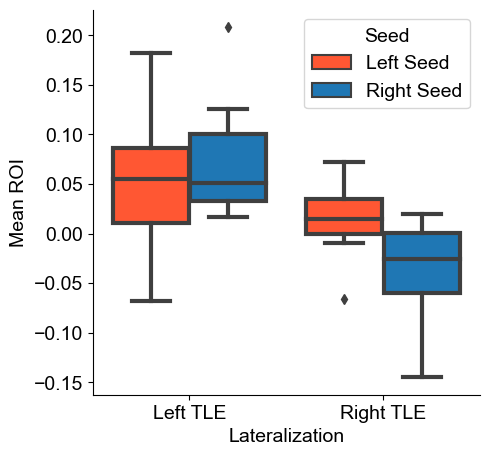

In [19]:
# Plot the connectivity to the PCC in 7T
df_plot_7t = pd.DataFrame()
df_plot_7t['Mean ROI'] = np.hstack([l_seed_l_tle_7t,r_seed_l_tle_7t,l_seed_r_tle_7t,r_seed_r_tle_7t])
df_plot_7t['Seed'] = ['Left Seed']*len(l_seed_l_tle_7t) + ['Right Seed']*len(r_seed_l_tle_7t) + ['Left Seed']*len(l_seed_r_tle_7t) + ['Right Seed']*len(r_seed_r_tle_7t)
df_plot_7t['Lateralization'] = ['Left TLE']*len(l_seed_l_tle_7t) + ['Left TLE']*len(r_seed_l_tle_7t) + ['Right TLE']*len(l_seed_r_tle_7t) + ['Right TLE']*len(r_seed_r_tle_7t)

colors = ["#FF5733","#1F77B4"]
sns.set_palette(colors)


plt.figure(figsize=(5,5))
sns.boxplot(x='Lateralization', y='Mean ROI', hue='Seed', data=df_plot_7t, linewidth=3, saturation=1)
sns.despine()



Paired t-test for comparing the left and right seeds in left and right TLE

In [24]:
print('R-TLE, paired t-test: ',stats.ttest_1samp(l_seed_r_tle_7t-r_seed_r_tle_7t, popmean=0))
print('L-TLE, paired t-test: ',stats.ttest_1samp(l_seed_l_tle_7t-r_seed_l_tle_7t, popmean=0))

R-TLE, paired t-test:  TtestResult(statistic=3.6562995910792737, pvalue=0.010626205202016566, df=6)
L-TLE, paired t-test:  TtestResult(statistic=-1.5106721626728499, pvalue=0.1590525193644964, df=11)


Left and right combined

In [25]:
stats.ttest_1samp(np.hstack([(l_seed_r_tle_7t-r_seed_r_tle_7t), 
(r_seed_l_tle_7t-l_seed_l_tle_7t)]),popmean=0)

TtestResult(statistic=3.1794374379105985, pvalue=0.005191843665645828, df=18)

In [26]:
df_plot = pd.DataFrame()
df_plot['Difference'] = np.hstack([l_seed_r_tle_7t-r_seed_r_tle_7t, r_seed_l_tle_7t-l_seed_l_tle_7t])


Measuring the difference in an already subtracted and smoothed seedmap

In [27]:
source_data='../../source_data/seed_based_analysis/'
info_7t = pd.read_excel('../../source_data/7T_MRI_Subjects.xlsx')

files = os.listdir(source_data)
files.remove('.DS_Store')

smoothed_difference_seed = []

subjects = []
for i in list(df_seed_all['Record ID'].values):
    try:
        smooth = zero_nan((nib.load(source_data+i+'/HarvardOxford/seed_map_difference_HarvardOxford_smoothed.nii.gz').get_fdata())[:,:,:,np.newaxis])
        smoothed_difference_seed.append(smooth)
        subjects.append(i)
    except:
        continue

In [28]:
df_seed_all['7T Left PCC Difference'] = get_mask_connectivity(np.concatenate(smoothed_difference_seed,axis=-1), left_pcc)
df_seed_all['7T Right PCC Difference'] = get_mask_connectivity(np.concatenate(smoothed_difference_seed,axis=-1), right_pcc)
df_seed_all['7T PCC Difference'] = get_mask_connectivity(np.concatenate(smoothed_difference_seed,axis=-1), pcc_all)

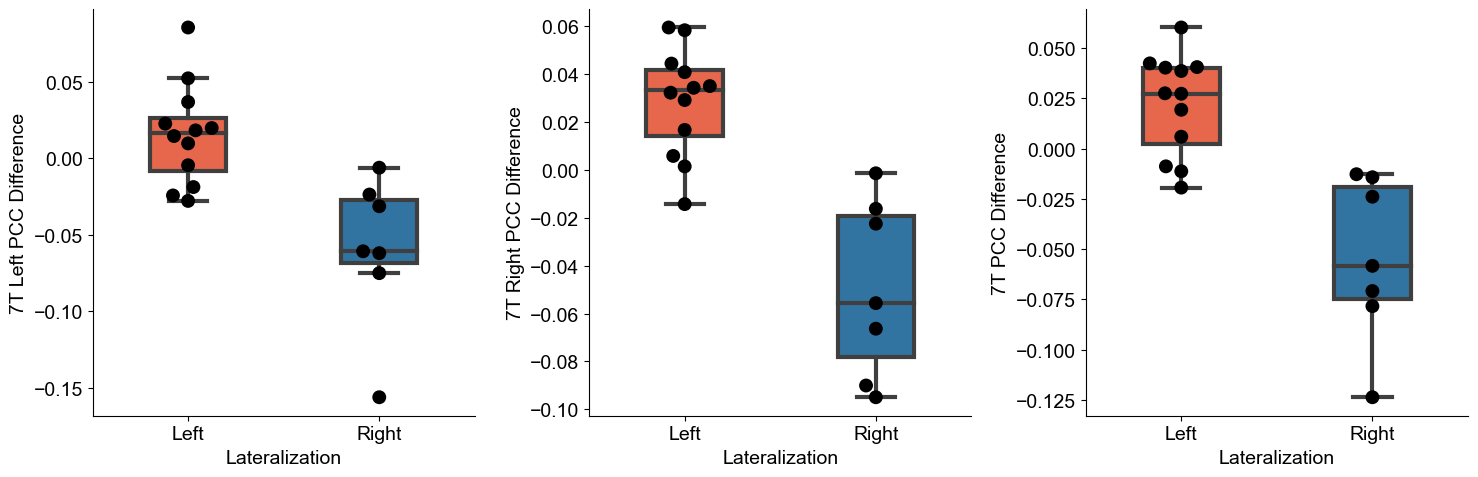

In [29]:


plt.figure(figsize=(15,5))
plt.subplot(131)
sns.boxplot(x='Lateralization', y='7T Left PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], linewidth=3, width=0.4)
sns.swarmplot(x='Lateralization', y='7T Left PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], size=10, color='k')
plt.subplot(132)
sns.boxplot(x='Lateralization', y='7T Right PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], linewidth=3, width=0.4)
sns.swarmplot(x='Lateralization', y='7T Right PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], size=10, color='k')
plt.subplot(133)
sns.boxplot(x='Lateralization', y='7T PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], linewidth=3, width=0.4)
sns.swarmplot(x='Lateralization', y='7T PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], size=10, color='k')
sns.despine()
plt.tight_layout()
#plt.savefig('7t_pcc_difference.pdf')

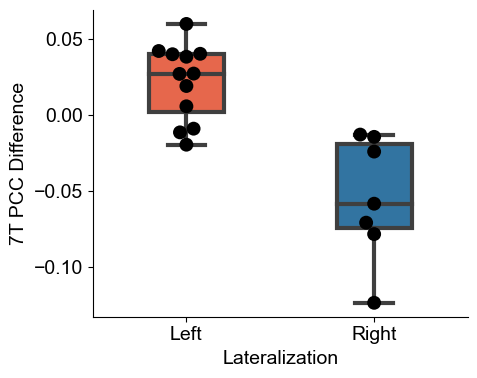

In [34]:
plt.figure(figsize=(5,4))
sns.boxplot(x='Lateralization', y='7T PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], linewidth=3, width=0.4)
sns.swarmplot(x='Lateralization', y='7T PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], size=10, color='k')
sns.despine()
plt.tight_layout()
plt.savefig('/Volumes/T7_Shield/research/CNT/P18_7T_rsfMRI/output/figures/figures_2023/7t_pcc_difference_updated.pdf')


In [30]:
len(df_seed_all[(df_seed_all['Lateralization']=='Left') | (df_seed_all['Lateralization']=='Right')])

19

In [31]:
# print values for ROC analysis
(df_seed_all[(df_seed_all['Lateralization']=='Left') | (df_seed_all['Lateralization']=='Right')]['Lateralization'].values == 'Left').astype(int)

array([1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0])

In [32]:
df_seed_all[(df_seed_all['Lateralization']=='Left') | (df_seed_all['Lateralization']=='Right')]['7T PCC Difference'].values 

array([ 0.04017217,  0.04230133,  0.00585933, -0.0239569 , -0.0583073 ,
        0.03851834, -0.0088675 , -0.01277053,  0.02743131, -0.01130491,
       -0.12358664,  0.06013358,  0.04045993,  0.01925188, -0.07832219,
       -0.01426906, -0.01942179,  0.02721249, -0.07080892])

In [199]:
df_seed_all[df_seed_all['Lateralization']=='Right'][['Record ID','7T PCC Difference']]

,Record ID,7T PCC Difference
6,sub-RID0121,-0.023957
7,sub-RID0455,-0.058307
12,sub-RID0522,-0.012771
15,sub-RID0572,-0.123587
22,sub-RID0032,-0.078322
23,sub-RID0117,-0.014269
27,sub-RID0693,-0.070809


In [200]:
# in the Right PCC vs in the overall PCC
stats.ttest_ind(df_seed_all[df_seed_all['Lateralization']=='Left']['7T Right PCC Difference'], df_seed_all[df_seed_all['Lateralization']=='Right']['7T Right PCC Difference'])


Ttest_indResult(statistic=5.784131539204748, pvalue=2.2009203079847246e-05)

In [201]:
# in the overall PCC
print(stats.ttest_ind(df_seed_all[df_seed_all['Lateralization']=='Left']['7T PCC Difference'], df_seed_all[df_seed_all['Lateralization']=='Right']['7T PCC Difference']))

print(cohend(df_seed_all[df_seed_all['Lateralization']=='Left']['7T PCC Difference'], df_seed_all[df_seed_all['Lateralization']=='Right']['7T PCC Difference']))

Ttest_indResult(statistic=5.105232171829224, pvalue=8.797501242968845e-05)
2.428022208646867


See if the MRI Version has an effect

<Axes: xlabel='7T Left PCC Difference', ylabel='7T Right PCC Difference'>

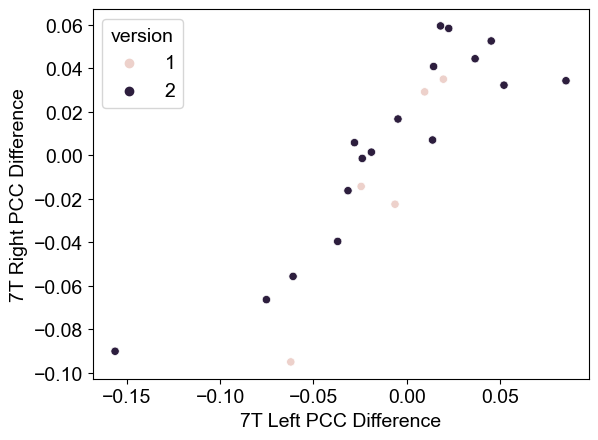

In [33]:
sns.scatterplot(x='7T Left PCC Difference', y='7T Right PCC Difference', hue='version', data=df_seed_all)

Does being lesional affect the findings from above?

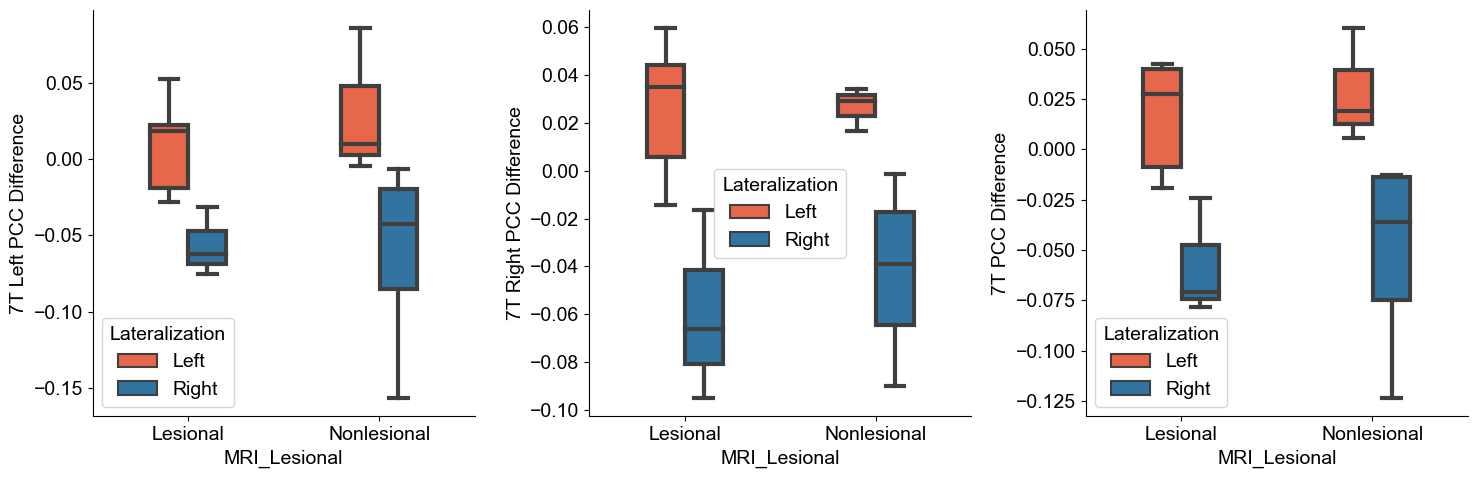

In [203]:
plt.figure(figsize=(15,5))
plt.subplot(131)
sns.boxplot(hue='Lateralization', y='7T Left PCC Difference', x='MRI_Lesional',data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], linewidth=3, width=0.4)
#sns.swarmplot(x='Lateralization', y='7T Left PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], size=10, color='k')
plt.subplot(132)
sns.boxplot(hue='Lateralization', y='7T Right PCC Difference', x='MRI_Lesional', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], linewidth=3, width=0.4)
#sns.swarmplot(x='Lateralization', y='7T Right PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], size=10, color='k')
plt.subplot(133)
sns.boxplot(hue='Lateralization', y='7T PCC Difference', x='MRI_Lesional', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], linewidth=3, width=0.4)
#sns.swarmplot(x='Lateralization', y='7T PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], size=10, color='k')
sns.despine()
plt.tight_layout()

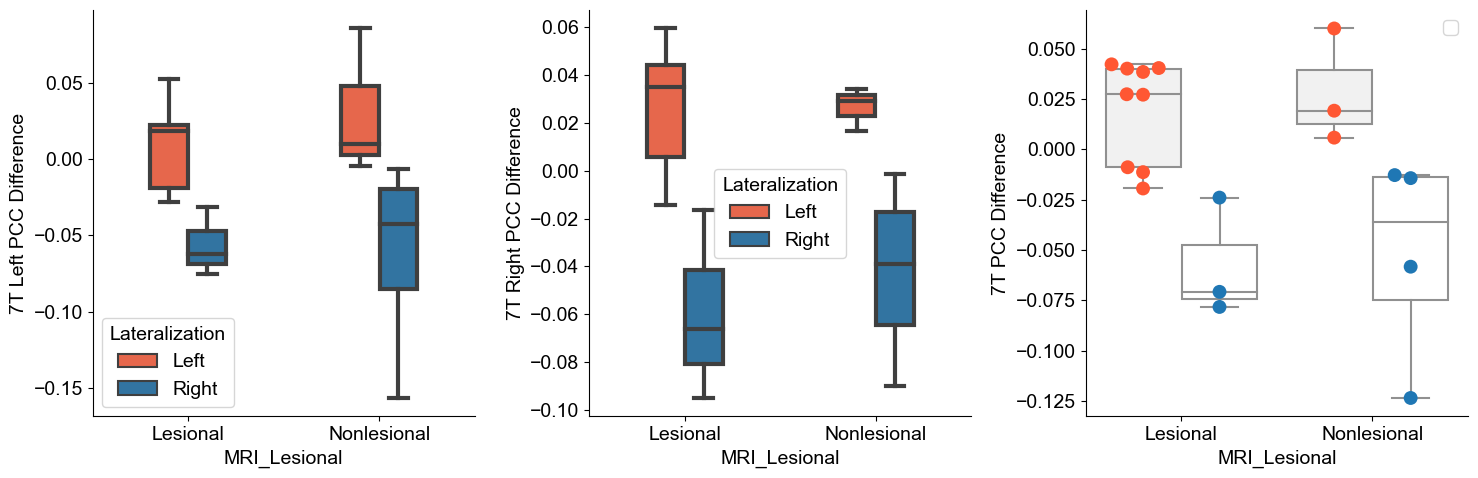

In [204]:
plt.figure(figsize=(15,5))
plt.subplot(131)
sns.boxplot(hue='Lateralization', y='7T Left PCC Difference', x='MRI_Lesional',data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], linewidth=3, width=0.4)
#sns.swarmplot(x='Lateralization', y='7T Left PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], size=10, color='k')
plt.subplot(132)
sns.boxplot(hue='Lateralization', y='7T Right PCC Difference', x='MRI_Lesional', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], linewidth=3, width=0.4)
#sns.swarmplot(x='Lateralization', y='7T Right PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], size=10, color='k')
plt.subplot(133)
sns.swarmplot(hue='Lateralization', y='7T PCC Difference', x='MRI_Lesional', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], dodge=True, size=10)
sns.boxplot(hue='Lateralization', y='7T PCC Difference', x='MRI_Lesional', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], color='white')
plt.legend([])
#sns.swarmplot(x='Lateralization', y='7T PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], size=10, color='k')
sns.despine()
plt.tight_layout()

#plt.savefig('7T_lesional_vs_nonlesional.pdf')

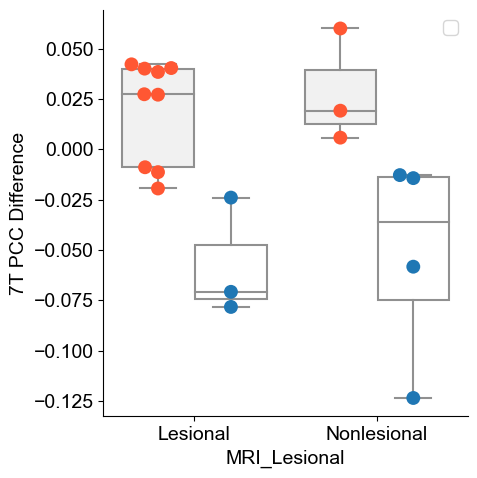

In [205]:
plt.figure(figsize=(5,5))
sns.swarmplot(hue='Lateralization', y='7T PCC Difference', x='MRI_Lesional', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], dodge=True, size=10)
sns.boxplot(hue='Lateralization', y='7T PCC Difference', x='MRI_Lesional', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], color='white')
plt.legend([])
#sns.swarmplot(x='Lateralization', y='7T PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], size=10, color='k')
sns.despine()
plt.tight_layout()
#plt.savefig('/Volumes/T7_Shield/research/CNT/P18_7T_rsfMRI/output/figures/figures_2023/7T_lesional_vs_nonlesional_updated.pdf')

In [206]:
print(bootstrap_t_test(df_seed_all[(df_seed_all['Lateralization']=='Left') & (df_seed_all['MRI_Lesional']=='Lesional')]['7T PCC Difference'], df_seed_all[(df_seed_all['Lateralization']=='Right') & (df_seed_all['MRI_Lesional']=='Lesional')]['7T PCC Difference']))


print(bootstrap_t_test(df_seed_all[(df_seed_all['Lateralization']=='Left') & (df_seed_all['MRI_Lesional']=='Nonlesional')]['7T PCC Difference'], df_seed_all[(df_seed_all['Lateralization']=='Right') & (df_seed_all['MRI_Lesional']=='Nonlesional')]['7T PCC Difference']))

0.01098901098901099
0.0969030969030969


In [207]:
df_seed_all[(df_seed_all['Lateralization']=='Right') & (df_seed_all['MRI_Lesional']=='Nonlesional')]['7T PCC Difference']

7    -0.058307
12   -0.012771
15   -0.123587
23   -0.014269
Name: 7T PCC Difference, dtype: float64

In [208]:
for les in ['Lesional','Nonlesional']:
    print(stats.mannwhitneyu(df_seed_all[(df_seed_all['Lateralization']=='Left') & (df_seed_all['MRI_Lesional']==les)]['7T PCC Difference'], df_seed_all[(df_seed_all['Lateralization']=='Right')  & (df_seed_all['MRI_Lesional']==les)]['7T PCC Difference']))
    print('Cohen\'s d: ', cohend(df_seed_all[(df_seed_all['Lateralization']=='Left') & (df_seed_all['MRI_Lesional']==les)]['7T PCC Difference'], df_seed_all[(df_seed_all['Lateralization']=='Right')  & (df_seed_all['MRI_Lesional']==les)]['7T PCC Difference']))

MannwhitneyuResult(statistic=27.0, pvalue=0.00909090909090909)
Cohen's d:  2.9484242168689883
MannwhitneyuResult(statistic=12.0, pvalue=0.05714285714285714)
Cohen's d:  1.8286165166596782


In [209]:
df_seed_all[['Record ID','Lateralization','Final_Lat']]

,Record ID,Lateralization,Final_Lat
1,sub-RID0420,Left,L
3,sub-RID0365,Left,L
5,sub-RID0448,Left,L
6,sub-RID0121,Right,R
7,sub-RID0455,Right,R
9,sub-RID0490,Left,L
11,sub-RID0508,Left,L
12,sub-RID0522,Right,R
13,sub-RID0520,Left,L
14,sub-RID0566,Left,L


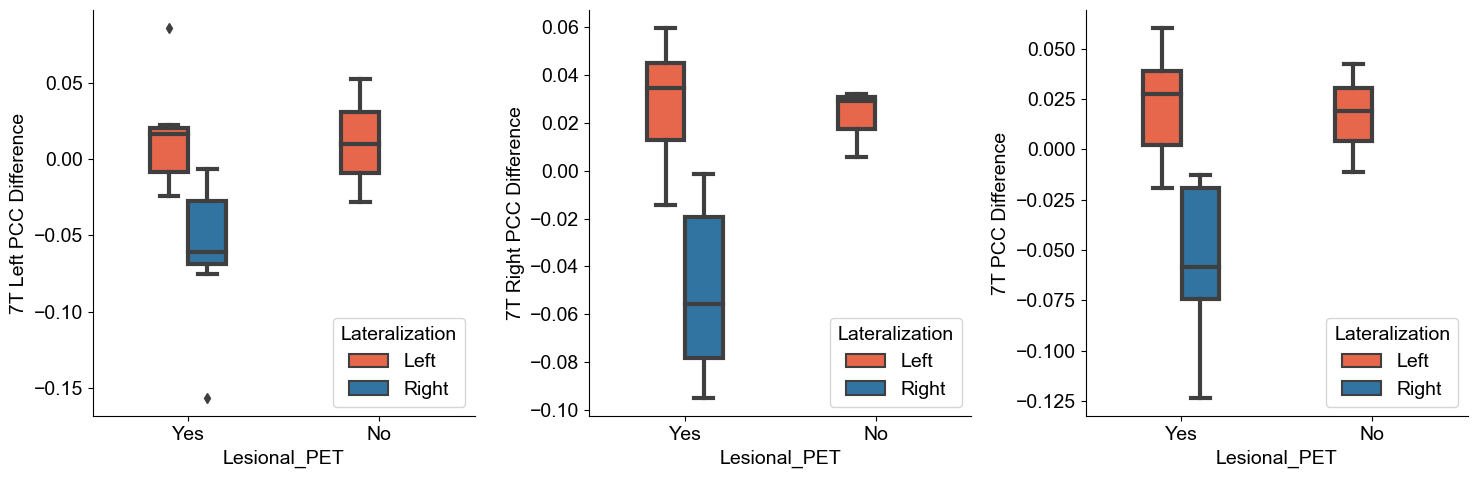

In [210]:
plt.figure(figsize=(15,5))
plt.subplot(131)
sns.boxplot(hue='Lateralization', y='7T Left PCC Difference', x='Lesional_PET',data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], linewidth=3, width=0.4)
#sns.swarmplot(x='Lateralization', y='7T Left PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], size=10, color='k')
plt.subplot(132)
sns.boxplot(hue='Lateralization', y='7T Right PCC Difference', x='Lesional_PET', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], linewidth=3, width=0.4)
#sns.swarmplot(x='Lateralization', y='7T Right PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], size=10, color='k')
plt.subplot(133)
sns.boxplot(hue='Lateralization', y='7T PCC Difference', x='Lesional_PET', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], linewidth=3, width=0.4)
#sns.swarmplot(x='Lateralization', y='7T PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], size=10, color='k')
sns.despine()
plt.tight_layout()

### 3T

Plot the connectivity to the PCC at 3T

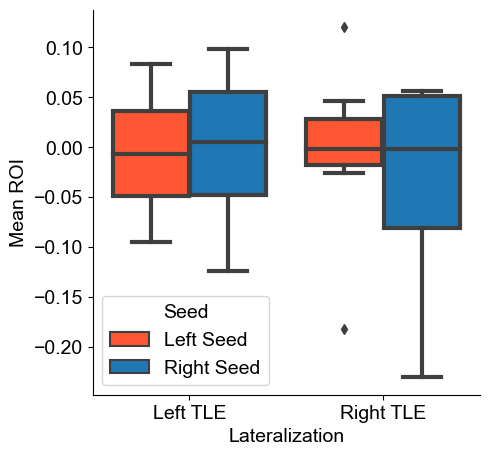

In [34]:
df_plot_3t = pd.DataFrame()
df_plot_3t['Mean ROI'] = np.hstack([l_seed_l_tle_3t,r_seed_l_tle_3t,l_seed_r_tle_3t,r_seed_r_tle_3t])
df_plot_3t['Seed'] = ['Left Seed']*len(l_seed_l_tle_3t) + ['Right Seed']*len(r_seed_l_tle_3t) + ['Left Seed']*len(l_seed_r_tle_3t) + ['Right Seed']*len(r_seed_r_tle_3t)
df_plot_3t['Lateralization'] = ['Left TLE']*len(l_seed_l_tle_3t) + ['Left TLE']*len(r_seed_l_tle_3t) + ['Right TLE']*len(l_seed_r_tle_3t) + ['Right TLE']*len(r_seed_r_tle_3t)

colors = ["#FF5733","#1F77B4"]
sns.set_palette(colors)


plt.figure(figsize=(5,5))
sns.boxplot(x='Lateralization', y='Mean ROI', hue='Seed', data=df_plot_3t, linewidth=3, saturation=1)
sns.despine()



Paired t-test for comparing the left and right seeds in left and right TLE

In [35]:
print('R-TLE, paired t-test: ',stats.ttest_1samp(l_seed_r_tle_3t-r_seed_r_tle_3t, popmean=0))
print('L-TLE, paired t-test: ',stats.ttest_1samp(l_seed_l_tle_3t-r_seed_l_tle_3t, popmean=0))

R-TLE, paired t-test:  TtestResult(statistic=0.6741835704685352, pvalue=0.5253030458003094, df=6)
L-TLE, paired t-test:  TtestResult(statistic=-0.4655618827061924, pvalue=0.6506110302691207, df=11)


In [36]:
ai_l_tle_7t = (l_seed_l_tle_7t-r_seed_l_tle_7t)/(l_seed_l_tle_7t+r_seed_l_tle_7t)
ai_r_tle_7t = (l_seed_r_tle_7t-r_seed_r_tle_7t)/(l_seed_r_tle_7t+r_seed_r_tle_7t)

df_plot = pd.DataFrame()
df_plot['AI'] = np.hstack((ai_l_tle_7t, ai_r_tle_7t))
df_plot['Group'] = ['Left TLE']*len(ai_l_tle_7t) + ['Right TLE']*len(ai_r_tle_7t)

Measuring the difference in an already subtracted and smoothed seedmap

In [37]:
source_data='../../source_data/seed_based_analysis_3t/'

smoothed_difference_seed = []

for i in list(df_seed_all['Record ID'].values):
    try:
        smooth = zero_nan((nib.load(source_data+i+'/HarvardOxford/seed_map_difference_HarvardOxford_smoothed.nii.gz').get_fdata())[:,:,:,np.newaxis])
        smoothed_difference_seed.append(smooth)
        subjects.append(i)
    except:
        continue

In [38]:
df_seed_all['3T Left PCC Difference'] = get_mask_connectivity(np.concatenate(smoothed_difference_seed,axis=-1), left_pcc)
df_seed_all['3T Right PCC Difference'] = get_mask_connectivity(np.concatenate(smoothed_difference_seed,axis=-1), right_pcc)
df_seed_all['3T PCC Difference'] = get_mask_connectivity(np.concatenate(smoothed_difference_seed,axis=-1), pcc_all)

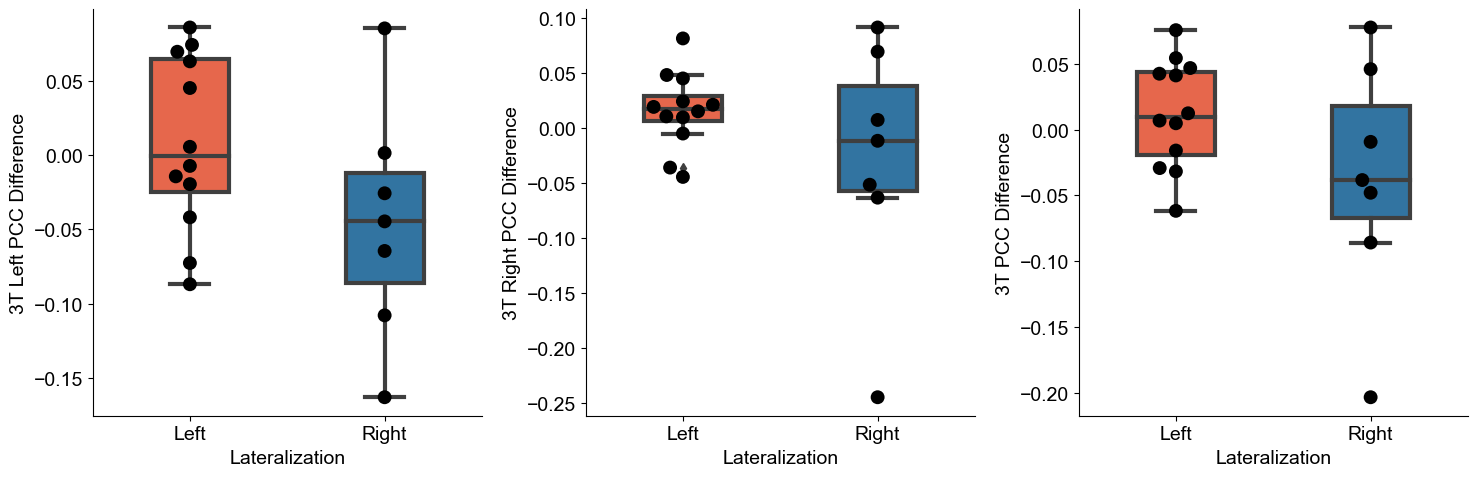

In [39]:
plt.figure(figsize=(15,5))
plt.subplot(131)
sns.boxplot(x='Lateralization', y='3T Left PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], linewidth=3, width=0.4)
sns.swarmplot(x='Lateralization', y='3T Left PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], size=10, color='k')
plt.subplot(132)
sns.boxplot(x='Lateralization', y='3T Right PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], linewidth=3, width=0.4)
sns.swarmplot(x='Lateralization', y='3T Right PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], size=10, color='k')
plt.subplot(133)
sns.boxplot(x='Lateralization', y='3T PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], linewidth=3, width=0.4)
sns.swarmplot(x='Lateralization', y='3T PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], size=10, color='k')
sns.despine()
plt.tight_layout()
#plt.savefig('3t_pcc_difference.pdf')


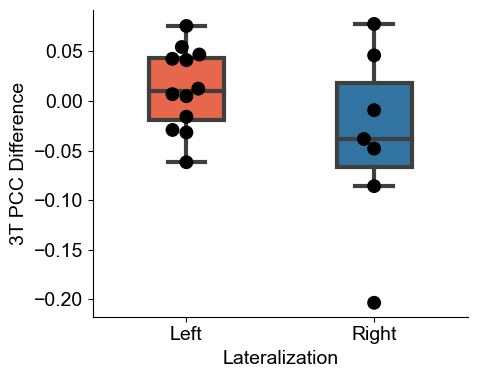

In [40]:
plt.figure(figsize=(5,4))
sns.boxplot(x='Lateralization', y='3T PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], linewidth=3, width=0.4)
sns.swarmplot(x='Lateralization', y='3T PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], size=10, color='k')
sns.despine()
plt.tight_layout()
#plt.savefig('/Volumes/T7_Shield/research/CNT/P18_7T_rsfMRI/output/figures/figures_2023/3t_pcc_difference_updated.pdf')

In [41]:
print(stats.ttest_ind(df_seed_all[df_seed_all['Lateralization']=='Left']['3T Right PCC Difference'], df_seed_all[df_seed_all['Lateralization']=='Right']['3T Right PCC Difference']))
print(cohend(df_seed_all[df_seed_all['Lateralization']=='Left']['3T Right PCC Difference'], df_seed_all[df_seed_all['Lateralization']=='Right']['3T Right PCC Difference']))

Ttest_indResult(statistic=1.3150473003088154, pvalue=0.20595751091524417)
0.6254297440554715


In [42]:
df_seed_all[(df_seed_all['Lateralization']=='Left') | (df_seed_all['Lateralization']=='Right')]['3T PCC Difference'].values 

array([ 0.05439137, -0.06168082,  0.04252684, -0.03829677, -0.00926499,
        0.00688877,  0.0048614 , -0.08579299, -0.03171802,  0.04683781,
        0.0776496 ,  0.0124369 , -0.01585855, -0.02918241, -0.20333152,
        0.04599284,  0.07562024,  0.04120098, -0.0479355 ])

See if the MRI Version has an effect

<Axes: xlabel='3T Left PCC Difference', ylabel='3T Right PCC Difference'>

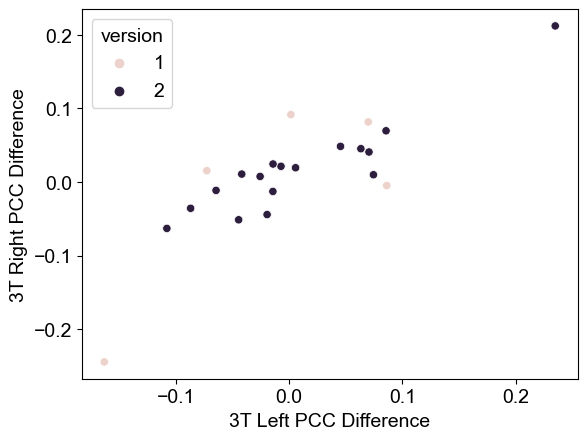

In [219]:
sns.scatterplot(x='3T Left PCC Difference', y='3T Right PCC Difference', hue='version', data=df_seed_all)

Does being lesional affect the findings from above?

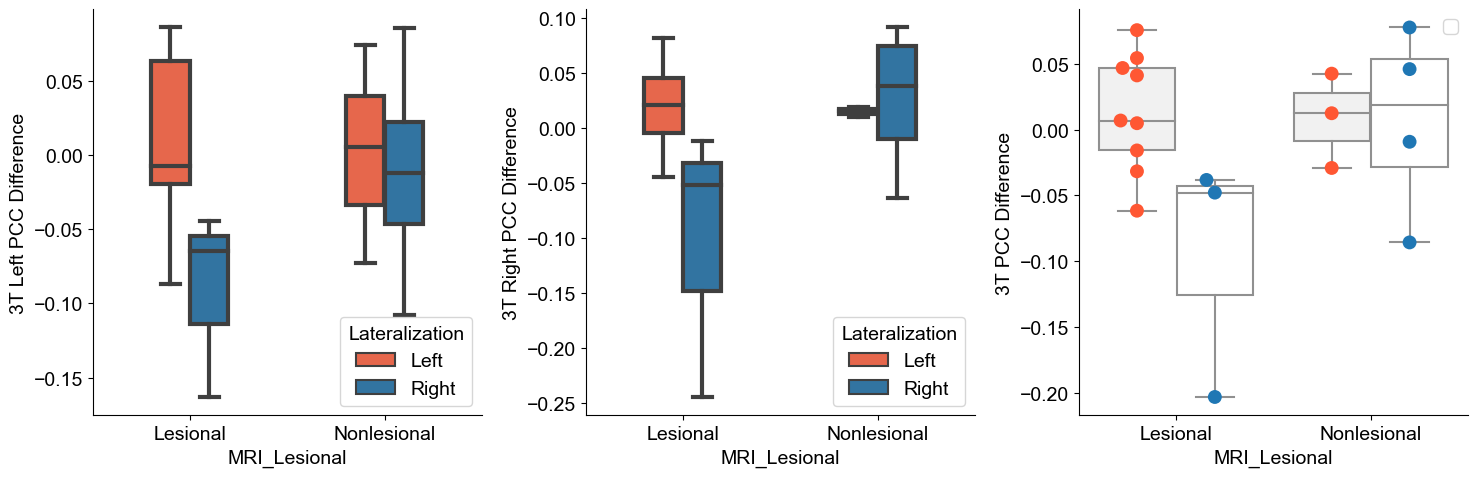

In [220]:
plt.figure(figsize=(15,5))
plt.subplot(131)
sns.boxplot(hue='Lateralization', y='3T Left PCC Difference', x='MRI_Lesional',data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], linewidth=3, width=0.4)
#sns.swarmplot(x='Lateralization', y='7T Left PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], size=10, color='k')
plt.subplot(132)
sns.boxplot(hue='Lateralization', y='3T Right PCC Difference', x='MRI_Lesional', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], linewidth=3, width=0.4)
#sns.swarmplot(x='Lateralization', y='7T Right PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], size=10, color='k')
plt.subplot(133)
plt.subplot(133)
sns.swarmplot(hue='Lateralization', y='3T PCC Difference', x='MRI_Lesional', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], dodge=True, size=10)
sns.boxplot(hue='Lateralization', y='3T PCC Difference', x='MRI_Lesional', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], color='white')
plt.legend([])
sns.despine()
plt.tight_layout()

#plt.savefig('3T_lesional_vs_nonlesional.pdf')

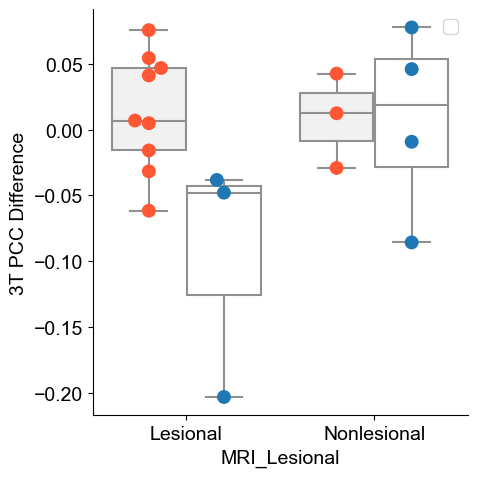

In [221]:
plt.figure(figsize=(5,5))
sns.swarmplot(hue='Lateralization', y='3T PCC Difference', x='MRI_Lesional', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], dodge=True, size=10)
sns.boxplot(hue='Lateralization', y='3T PCC Difference', x='MRI_Lesional', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], color='white')
plt.legend([])
sns.despine()
plt.tight_layout()
plt.savefig('/Volumes/T7_Shield/research/CNT/P18_7T_rsfMRI/output/figures/figures_2023/3t_lesional_vs_nonlesional_updated.pdf')

In [222]:
for les in ['Lesional','Nonlesional']:
    print(stats.mannwhitneyu(df_seed_all[(df_seed_all['Lateralization']=='Left') & (df_seed_all['MRI_Lesional']==les)]['3T PCC Difference'], df_seed_all[(df_seed_all['Lateralization']=='Right')  & (df_seed_all['MRI_Lesional']==les)]['3T PCC Difference']))
    print('Cohen\'s d: ', cohend(df_seed_all[(df_seed_all['Lateralization']=='Left') & (df_seed_all['MRI_Lesional']==les)]['3T PCC Difference'], df_seed_all[(df_seed_all['Lateralization']=='Right')  & (df_seed_all['MRI_Lesional']==les)]['3T PCC Difference']))

MannwhitneyuResult(statistic=25.0, pvalue=0.03636363636363636)
Cohen's d:  1.9062855537000585
MannwhitneyuResult(statistic=5.0, pvalue=0.8571428571428571)
Cohen's d:  0.024140990705010315


## Save the dataframe with all the data up until this point in the analysis

In [223]:
pd.to_pickle(df_seed_all,'df_seed_all_2_27_23.pkl')

## Do the findings generalize to patients without TLE or is this specific to TLE?

### 7T

In [43]:
info_3t = pd.read_excel('../../source_data/noddi_demo_surgical_outcomes_updated.xlsx')

df_seed_lat = df_seed[(df_seed['Lateralization']=='Left') | (df_seed['Lateralization']=='Right')]
cols = list(df_seed_lat.columns)
cols[0] = 'Subject'
df_seed_lat.columns = cols
df_seed_lat = pd.merge(df_seed_lat, info_3t, on='Subject')
df_seed_lat = df_seed_lat[(df_seed_lat['Final_Lat']=='L') | (df_seed_lat['Final_Lat']=='R')]

In [44]:
print(len(df_seed_lat))

27


In [45]:
source_data='../../source_data/seed_based_analysis/'

smoothed_difference_seed_lat = []
subjects_lat = []
for i in list(df_seed_lat['Subject'].values):
    try:
        smooth = zero_nan((nib.load(source_data+i+'/HarvardOxford/seed_map_difference_HarvardOxford_smoothed.nii.gz').get_fdata())[:,:,:,np.newaxis])
        smoothed_difference_seed_lat.append(smooth)
        subjects.append(i)
    except:
        continue

In [46]:
df_seed_lat['7T Left PCC Difference'] = get_mask_connectivity(np.concatenate(smoothed_difference_seed_lat,axis=-1), left_pcc)
df_seed_lat['7T Right PCC Difference'] = get_mask_connectivity(np.concatenate(smoothed_difference_seed_lat,axis=-1), right_pcc)
df_seed_lat['7T PCC Difference'] = get_mask_connectivity(np.concatenate(smoothed_difference_seed_lat,axis=-1), pcc_all)

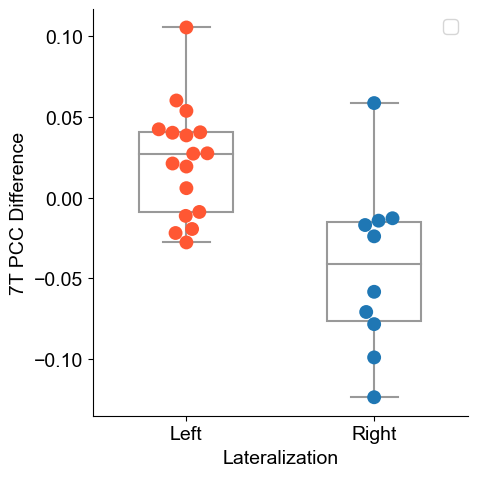

In [47]:
plt.figure(figsize=(5,5))
colors = ["#FF5733","#1F77B4"]
sns.set_palette(colors)

sns.swarmplot(x='Lateralization', y='7T PCC Difference', data=df_seed_lat, dodge=True, size=10)
sns.boxplot(x='Lateralization', y='7T PCC Difference', data=df_seed_lat, color='white', width=0.5)
#sns.swarmplot(x='Lateralization', y='7T PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], color='k', size=10)

plt.legend([])
sns.despine()
plt.tight_layout()
#plt.savefig('7t_extended_subjects_updated.pdf')

Text(0.5, 0, 'Protocol Version')

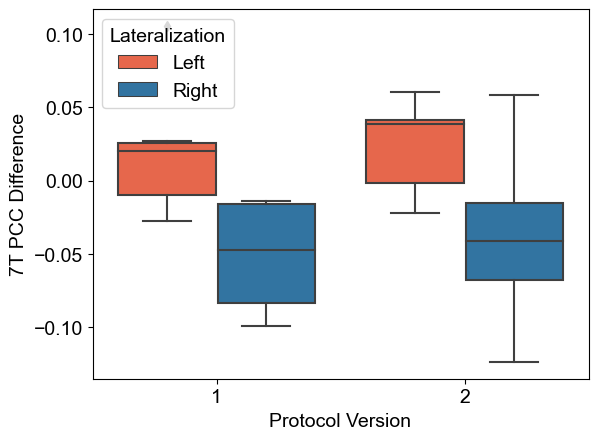

In [241]:
sns.boxplot(x='version', y='7T PCC Difference', hue='Lateralization', data=df_seed_lat)
plt.xlabel('Protocol Version')

In [237]:
df_seed_lat.to_pickle('df_seed_lat_2_27_23.pkl')

In [48]:
print('t-test:',stats.ttest_ind(df_seed_lat[df_seed_lat['Lateralization']=='Left']['7T PCC Difference'],df_seed_lat[df_seed_lat['Lateralization']=='Right']['7T PCC Difference']))

print('Cohen\'s d:', cohend(df_seed_lat[df_seed_lat['Lateralization']=='Left']['7T PCC Difference'],df_seed_lat[df_seed_lat['Lateralization']=='Right']['7T PCC Difference']))

t-test: Ttest_indResult(statistic=3.9988310703913554, pvalue=0.0004969332394915519)
Cohen's d: 1.5936409443144677


#### Lesional vs. Non-lesional

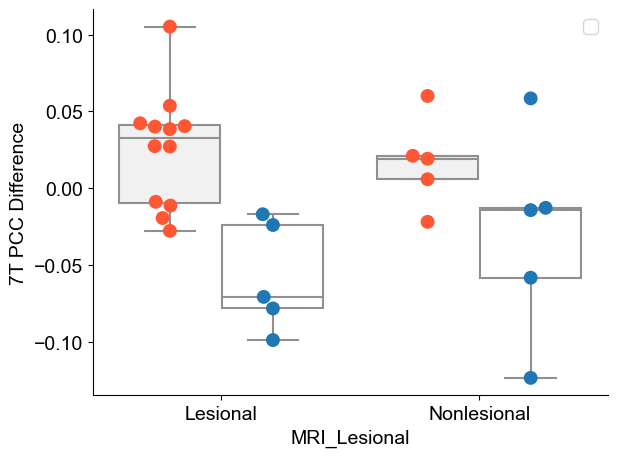

In [232]:
sns.swarmplot(hue='Lateralization', y='7T PCC Difference', x='MRI_Lesional', data=df_seed_lat, dodge=True, size=10)
sns.boxplot(hue='Lateralization', y='7T PCC Difference', x='MRI_Lesional', data=df_seed_lat, color='white')
plt.legend([])
sns.despine()
plt.tight_layout()

In [49]:
for les in ['Lesional','Nonlesional']:
    print(stats.mannwhitneyu(df_seed_lat[(df_seed_lat['Lateralization']=='Left') & (df_seed_lat['MRI_Lesional']==les)]['7T PCC Difference'], df_seed_lat[(df_seed_lat['Lateralization']=='Right')  & (df_seed_lat['MRI_Lesional']==les)]['7T PCC Difference']))
    print('Cohen\'s d: ', cohend(df_seed_lat[(df_seed_lat['Lateralization']=='Left') & (df_seed_lat['MRI_Lesional']==les)]['7T PCC Difference'], df_seed_lat[(df_seed_lat['Lateralization']=='Right')  & (df_seed_lat['MRI_Lesional']==les)]['7T PCC Difference']))

MannwhitneyuResult(statistic=57.0, pvalue=0.002262443438914027)
Cohen's d:  2.254530287778315
MannwhitneyuResult(statistic=19.0, pvalue=0.2222222222222222)
Cohen's d:  0.9068220602828836


this Mann-Whitney-U test for the Non-lesional group is not significant because of sample size.

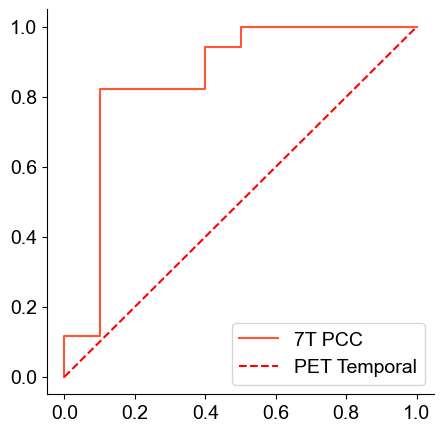

In [234]:
from sklearn.metrics import roc_curve, auc

y = (df_seed_lat['Lateralization']=='Left').astype(int)
X = df_seed_lat['7T PCC Difference'].values

fpr_7t, tpr_7t, _ = roc_curve(y==1, X)
plt.figure(figsize=(5,5))
plt.plot(fpr_7t, tpr_7t)
plt.plot([0,1],[0,1], c='r', linestyle='--')
plt.legend(['7T PCC','PET Temporal','PET MTL'])
sns.despine()

In [235]:
df_seed_lat2 = df_seed_lat.copy()
cols = list(df_seed_lat2.columns)
cols[0] = 'Subject'
df_seed_lat2.columns = cols
df_seed_lat2 = pd.merge(df_seed_lat2, info_3t, on='Subject')

In [238]:
set(list(df_seed_lat2['Subject'])) - set(list(df_seed_lat['Record ID']))

KeyError: 'Record ID'

In [ ]:
set(list(df_seed_lat2['Subject'])).symmetric_difference(set(list(df_seed_lat['Record ID'])))

{'sub-RID0029',
 'sub-RID0047',
 'sub-RID0075',
 'sub-RID0086',
 'sub-RID0119',
 'sub-RID0121',
 'sub-RID0124',
 'sub-RID0325',
 'sub-RID0367',
 'sub-RID0390',
 'sub-RID0489',
 'sub-RID0573',
 'sub-RID0619'}

In [ ]:
df_seed_lat[df_seed_lat['Record ID']=='sub-RID0619']['MRN']

34    452912157
Name: MRN, dtype: object

In [ ]:
df_seed_lat[df_seed_lat['Record ID']=='sub-RID0573']['Lateralization']

14    Right
Name: Lateralization, dtype: object

### 3T

In [50]:
df_seed_lat_3t = df_seed_3t[((df_seed_3t['Final_Lat']=='L') | (df_seed_3t['Final_Lat']=='R'))&((df_seed_3t['Final_Loc']=='Temporal'))]

In [51]:
source_data='../../source_data/seed_based_analysis_3t/'

smoothed_difference_seed_lat = []
subjects_lat = []
for i in list(df_seed_lat_3t['Record ID'].values):
        smooth = zero_nan((nib.load(source_data+i+'/HarvardOxford/seed_map_difference_HarvardOxford_smoothed.nii.gz').get_fdata())[:,:,:,np.newaxis])
        smoothed_difference_seed_lat.append(smooth)
        subjects.append(i)


In [52]:
df_seed_lat_3t['3T Left PCC Difference'] = get_mask_connectivity(np.concatenate(smoothed_difference_seed_lat,axis=-1), left_pcc)
df_seed_lat_3t['3T Right PCC Difference'] = get_mask_connectivity(np.concatenate(smoothed_difference_seed_lat,axis=-1), right_pcc)
df_seed_lat_3t['3T PCC Difference'] = get_mask_connectivity(np.concatenate(smoothed_difference_seed_lat,axis=-1), pcc_all)

/var/folders/cd/2tvrfhlx5cnbjft2fv0kn5gr0000gn/T/ipykernel_10221/3595435213.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seed_lat_3t['3T Left PCC Difference'] = get_mask_connectivity(np.concatenate(smoothed_difference_seed_lat,axis=-1), left_pcc)
/var/folders/cd/2tvrfhlx5cnbjft2fv0kn5gr0000gn/T/ipykernel_10221/3595435213.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seed_lat_3t['3T Right PCC Difference'] = get_mask_connectivity(np.concatenate(smoothed_difference_seed_lat,axis=-1), right_p

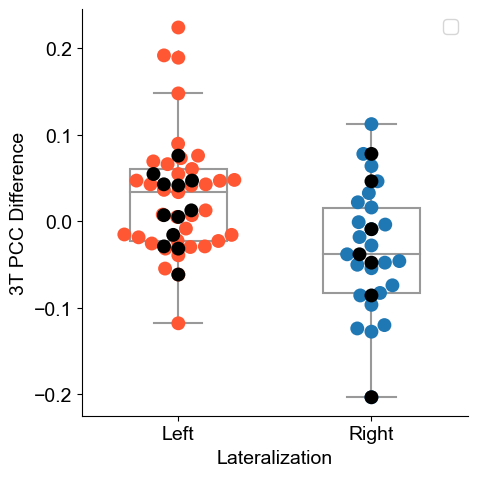

In [53]:
plt.figure(figsize=(5,5))
colors = ["#FF5733","#1F77B4"]
sns.set_palette(colors)

sns.swarmplot(x='Final_Lat', y='3T PCC Difference', order=['L','R'],data=df_seed_lat_3t, dodge=True, size=10)
sns.boxplot(x='Final_Lat', y='3T PCC Difference', order=['L','R'], data=df_seed_lat_3t, color='white', width=0.5)
sns.swarmplot(x='Lateralization', y='3T PCC Difference', data=df_seed_all[df_seed_all['Lateralization']!='Bilateral'], color='k', size=10)

plt.legend([])
sns.despine()
plt.tight_layout()
#plt.savefig('/Volumes/T7_Shield/research/CNT/P18_7T_rsfMRI/output/figures/figures_2023/3t_all_subjects_updated.pdf')

In [54]:
print('t-test:',stats.ttest_ind(df_seed_lat_3t[df_seed_lat_3t['Final_Lat']=='L']['3T PCC Difference'],df_seed_lat_3t[df_seed_lat_3t['Final_Lat']=='R']['3T PCC Difference']))
print('Cohen\'s d:', cohend(df_seed_lat_3t[df_seed_lat_3t['Final_Lat']=='L']['3T PCC Difference'],df_seed_lat_3t[df_seed_lat_3t['Final_Lat']=='R']['3T PCC Difference']))

t-test: Ttest_indResult(statistic=3.402613900444347, pvalue=0.001193838616576306)
Cohen's d: 0.8809223937600367


In [56]:
len(df_seed_lat_3t)

62

In [57]:
df_seed_lat_3t.to_pickle('df_seed_lat_3t_3_21_23.pkl')

#### Lesional vs. Non-lesional

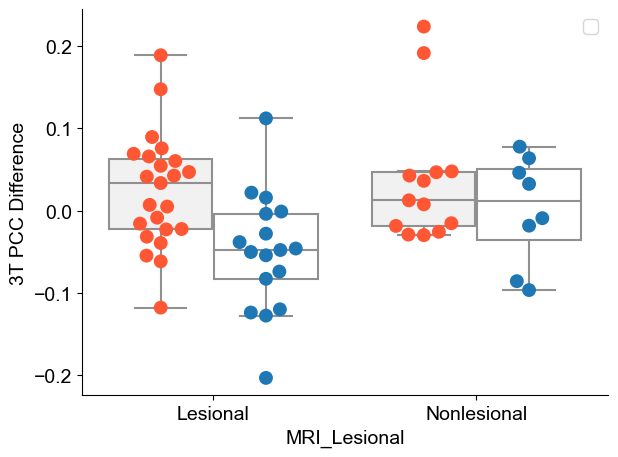

In [58]:
sns.swarmplot(hue='Final_Lat', y='3T PCC Difference', x='MRI_Lesional', data=df_seed_lat_3t, dodge=True, size=10)
sns.boxplot(hue='Final_Lat', y='3T PCC Difference', x='MRI_Lesional', data=df_seed_lat_3t, color='white')
plt.legend([])
sns.despine()
plt.tight_layout()

In [81]:
for les in ['Lesional','Nonlesional']:
    print(stats.mannwhitneyu(df_seed_lat_3t[(df_seed_lat_3t['Final_Lat']=='L') & (df_seed_lat_3t['MRI_Lesional']==les)]['3T PCC Difference'], df_seed_lat_3t[(df_seed_lat_3t['Final_Lat']=='R')  & (df_seed_lat_3t['MRI_Lesional']==les)]['3T PCC Difference']))
    print('Cohen\'s d: ', cohend(df_seed_lat_3t[(df_seed_lat_3t['Final_Lat']=='L') & (df_seed_lat_3t['MRI_Lesional']==les)]['3T PCC Difference'], df_seed_lat_3t[(df_seed_lat_3t['Final_Lat']=='R')  & (df_seed_lat_3t['MRI_Lesional']==les)]['3T PCC Difference']))

MannwhitneyuResult(statistic=307.0, pvalue=0.0023900919538782863)
Cohen's d:  1.0550492010519261
MannwhitneyuResult(statistic=57.0, pvalue=0.7501007420512065)
Cohen's d:  0.47981107615626545


### Permute the Cohen's d

In [129]:
def cohend(d1, d2):
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = np.nanvar(d1, ddof=1), np.nanvar(d2, ddof=1)
	# calculate the pooled standard deviation
	s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = np.nanmean(d1), np.nanmean(d2)
	# calculate the effect size
	return (u1 - u2) / s

In [130]:
cohend_list = []
for i in tqdm(range(1000)):
    sample = df_seed_lat_3t.sample(27)
    c = cohend(sample[sample['Final_Lat']=='L']['3T PCC Difference'].values, sample[sample['Final_Lat']=='R']['3T PCC Difference'].values)
    cohend_list.append(c)

100%|██████████| 1000/1000 [00:00<00:00, 1907.49it/s]


In [131]:
cohend_7t = cohend(df_seed_lat[df_seed_lat['Lateralization']=='Left']['7T PCC Difference'].values, df_seed_lat[df_seed_lat['Lateralization']=='Right']['7T PCC Difference'].values)

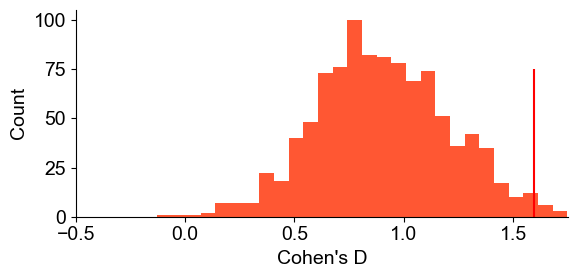

In [132]:
plt.figure(figsize=(6,3))
plt.hist(cohend_list, bins=30)
plt.vlines(x=cohend_7t, ymin=0, ymax=75, color='red')
plt.xlim([-0.5,1.75])
sns.despine()
plt.xlabel('Cohen\'s D')
plt.ylabel('Count')
plt.tight_layout()

In [133]:
np.mean(cohend_list)

0.9033269112659877

### Permute the ROC

In [142]:
from sklearn.metrics import roc_curve, auc

def get_roc(sample):
    y = (sample['Final_Lat']=='L').astype(int)
    X = sample['3T PCC Difference'].values
    fpr, tpr, _ = roc_curve(y==1, X)
    return fpr, tpr

In [143]:
y = (df_seed_lat['Lateralization']=='Left').astype(int)
X = df_seed_lat['7T PCC Difference'].values
fpr_7t, tpr_7t, _ = roc_curve(y==1, X)

100%|██████████| 1000/1000 [00:00<00:00, 1062.96it/s]


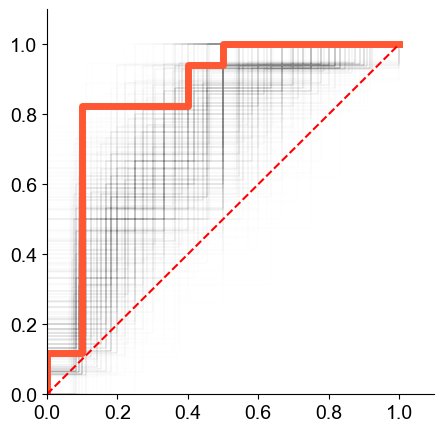

In [144]:
plt.figure(figsize=(5,5))
fpr_list = []
tpr_list = []
auc_list = []
for i in tqdm(range(1000)):
    sample = df_seed_lat_3t.sample(27)
    fpr, tpr = get_roc(sample)
    plt.plot(fpr, tpr, linewidth=0.1, color='gray', alpha=0.1)
    auc_list.append(auc(fpr,tpr))
    fpr_list.append(fpr)
    tpr_list.append(tpr)

plt.xlim([0,1.1])
plt.ylim([0,1.1])
sns.despine()
plt.plot(fpr_7t, tpr_7t, linewidth=5)
plt.plot([0,1],[0,1], color='r', linestyle='--')

7T AUC:  0.8529411764705883


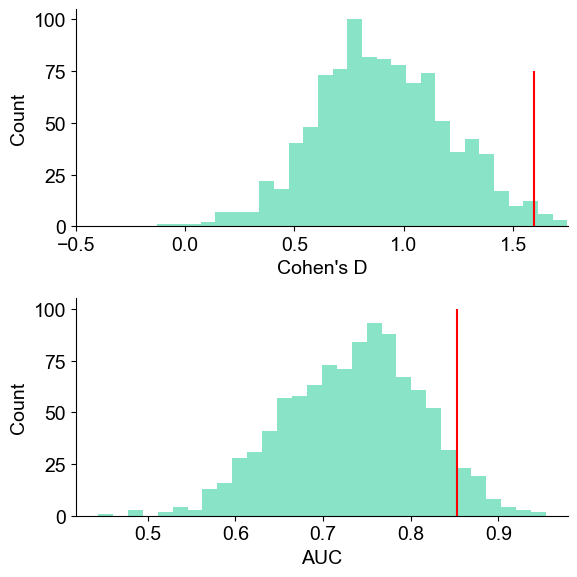

In [157]:
plt.figure(figsize=(6,6))
plt.subplot(211)
plt.hist(cohend_list, bins=30, color='#89E3C6')
plt.vlines(x=cohend_7t, ymin=0, ymax=75, color='red')
plt.xlim([-0.5,1.75])
sns.despine()
plt.xlabel('Cohen\'s D')
plt.ylabel('Count')
plt.tight_layout()

plt.subplot(212)
plt.hist(auc_list, bins=30, color='#89E3C6')
plt.vlines(auc(fpr_7t, tpr_7t), ymin=0, ymax=100, color='r')
print('7T AUC: ', auc(fpr_7t, tpr_7t))
sns.despine()
plt.xlabel('AUC')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('cohend_auc_permutations_2.pdf')

In [146]:
print('7T AUC: ', auc(fpr_7t, tpr_7t))

7T AUC:  0.8529411764705883


In [147]:
(np.sum(auc_list> auc(fpr_7t, tpr_7t))+1)/1001

0.056943056943056944

In [148]:
print('AUC 95%:',np.array(auc_list)[np.argsort(auc_list)[950]])
print('AUC 5%:',np.array(auc_list)[np.argsort(auc_list)[50]])

AUC 95%: 0.8579545454545454
AUC 5%: 0.6043956043956044


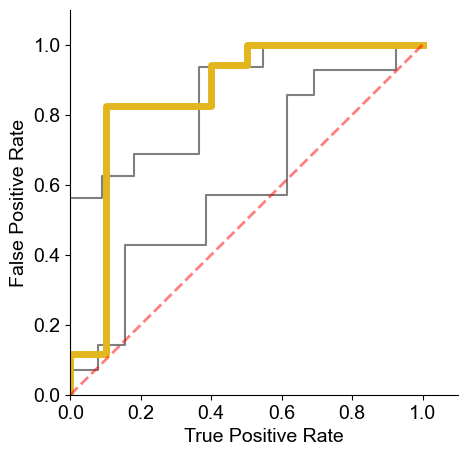

In [156]:
plt.figure(figsize=(5,5))
plt.plot(fpr_list[np.argsort(auc_list)[950]],tpr_list[np.argsort(auc_list)[950]], color='k', alpha=0.5)

plt.plot(fpr_list[np.argsort(auc_list)[50]],tpr_list[np.argsort(auc_list)[50]], color='k', alpha=0.5)


plt.xlim([0,1.1])
plt.ylim([0,1.1])
sns.despine()
plt.plot(fpr_7t, tpr_7t, linewidth=5, color='#E4B61D')
plt.plot([0,1],[0,1], color='r', linestyle='--', alpha=0.5, linewidth=2)
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.savefig('ROC_3t_all_7t_updated.pdf')


In [160]:
np.mean(auc_list)

0.7335456173246163

In [120]:
fpr_list

[array([0.        , 0.        , 0.        , 0.07692308, 0.07692308,
        0.15384615, 0.15384615, 0.23076923, 0.23076923, 0.38461538,
        0.38461538, 0.61538462, 0.61538462, 0.69230769, 0.69230769,
        0.76923077, 0.76923077, 0.84615385, 0.84615385, 1.        ]),
 array([0. , 0. , 0. , 0.1, 0.1, 0.2, 0.2, 0.5, 0.5, 0.6, 0.6, 0.7, 0.7,
        1. ]),
 array([0. , 0. , 0. , 0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5,
        1. ]),
 array([0.   , 0.   , 0.   , 0.125, 0.125, 0.25 , 0.25 , 0.5  , 0.5  ,
        0.625, 0.625, 1.   ]),
 array([0.        , 0.        , 0.        , 0.08333333, 0.08333333,
        0.16666667, 0.16666667, 0.33333333, 0.33333333, 0.66666667,
        0.66666667, 0.83333333, 0.83333333, 1.        ]),
 array([0. , 0. , 0. , 0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.7, 0.7,
        1. ]),
 array([0. , 0. , 0. , 0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5,
        0.7, 0.7, 0.8, 0.8, 1. ]),
 array([0.        , 0.        , 0.        , 0.18181818, 0.

## Are PCC difference values correlated between 3T and 7T?

In [333]:
df_seed_lr = df_seed_all[df_seed_all['Lateralization']!='Bilateral']

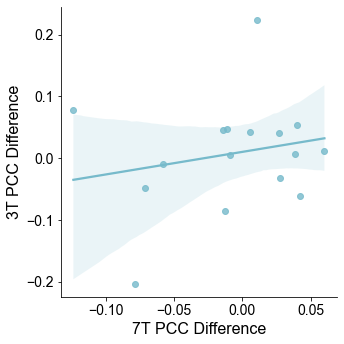

In [334]:
sns.lmplot(x='7T PCC Difference', y='3T PCC Difference', data=df_seed_lr)

In [335]:
stats.pearsonr(df_seed_lr['7T PCC Difference'].values, df_seed_lr['3T PCC Difference'].values)

(0.20845030607637122, 0.43849653020774837)

## Load and harmonize the extended 3T Cohort

Here we will include all of the 3T subjects to see whether the increased sample size replicates the results seen in 7T

In [602]:
source_data='/Users/allucas/Documents/research/CNT/P18_7T_rsfMRI/source_data/seed_based_analysis_3t_all/'
info_3t = pd.read_excel('/Users/allucas/Documents/research/CNT/P18_7T_rsfMRI/source_data/noddi_demo_surgical_outcomes.xlsx')

protocols_3t = pd.read_csv('/Users/allucas/Documents/research/CNT/P18_7T_rsfMRI/source_data/scanning_params_eli_3t.csv')

files = os.listdir(source_data)
#files.remove('.DS_Store')

left_seed_3t = []
right_seed_3t = []
subjects_3t = []

for i in range(len(files)):
    try:
        l = (nib.load(source_data+files[i]+'/HarvardOxford/seed_map_lh_HarvardOxford.nii.gz').get_fdata()*brain_mask)[:,:,:,np.newaxis]
        r = (nib.load(source_data+files[i]+'/HarvardOxford/seed_map_rh_HarvardOxford.nii.gz').get_fdata()*brain_mask)[:,:,:,np.newaxis]
        affine = nib.load(source_data+files[i]+'/HarvardOxford/seed_map_rh_HarvardOxford.nii.gz').affine
        left_seed_3t.append(l)
        right_seed_3t.append(r)
        subjects_3t.append(files[i])
    except:
        continue

fig_outpath = '/Users/allucas/Documents/research/CNT/P18_7T_rsfMRI/output/figures/'


In [603]:
df_seed_3t = pd.DataFrame()
df_seed_3t['LH Seed 3t'] = left_seed_3t
df_seed_3t['RH Seed 3t'] = right_seed_3t
df_seed_3t['Subject'] = subjects_3t
df_seed_3t['Record ID'] = subjects_3t
df_seed_3t = pd.merge(info_3t,df_seed_3t, on='Subject')
df_seed_3t = pd.merge(protocols_3t, df_seed_3t, on='Subject')
#df_seed_3t = df_seed_3t[(df_seed_3t['Group']=='Control')|(df_seed_3t['7T']=='Yes')]
df_seed_3t = df_seed_3t[((df_seed_3t['Final_Lat']=='L')|(df_seed_3t['Final_Lat']=='R'))&(df_seed_3t['Final_Loc']=='Temporal')]


In [604]:
from neuroCombat import neuroCombat
version = (df_seed_3t['protocol_number'].values>1).astype(int)
covariate = df_seed_3t['Final_Lat'].astype('category').cat.codes.values

X = []
for i in range(len(df_seed_3t)):
    X.append(np.concatenate((df_seed_3t.iloc[i]['LH Seed 3t'].ravel(),df_seed_3t.iloc[i]['RH Seed 3t'].ravel())))
    #X.append((df_seed_3t.iloc[i]['LH Seed 3t'].ravel()[int(0.4e6):int(0.41e6)]))

X = np.vstack(X).T

X[np.isnan(X)] = 0.01

covars = {'batch':version, 'type':covariate} 
covars = pd.DataFrame(covars)  

# To specify names of the variables that are categorical:
categorical_cols = ['type']

# To specify the name of the variable that encodes for the scanner/batch covariate:
batch_col = 'batch'

#Harmonization step:
data_combat = neuroCombat(dat=X,
    covars=covars,
    batch_col=batch_col, categorical_cols=categorical_cols)["data"]

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


In [605]:
# reshape harmonized data back to normal

x,y,z,_ = df_seed_3t.iloc[0]['LH Seed 3t'].shape

left_harm = []
right_harm = []
for i in range(data_combat.shape[1]):
    left_harm.append(data_combat[:x*y*z,i].reshape(x,y,z,1))

    right_harm.append(data_combat[x*y*z:,i].reshape(x,y,z,1))

df_seed_3t['LH Seed 3t harm'] = left_harm
df_seed_3t['RH Seed 3t harm'] = right_harm


In [614]:
# save the demographic information for all the 3T subjects
age_df = pd.read_excel('/Users/allucas/Documents/research/CNT/P18_7T_rsfMRI/source_data/noddi_demo_surgical_outcomes_age.xlsx')
age_df = age_df[['Subject','Age']]
df_seed_3t_table = pd.merge(age_df,df_seed_3t[['Subject','Sex','Final_Loc','Final_Lat', 'Etiology', 'MRI_Lesion_Loc','MRI_Lesional','Surgical_Outcome_all', 'protocol_number']])
df_seed_3t_table['MTS'] = df_seed_3t_table['Etiology']=='MTS'
df_seed_3t_table.to_excel('/Users/allucas/Documents/research/CNT/P18_7T_rsfMRI/source_data/subjects_3t_replication_subject_info.xlsx')


# Statistical Analysis 

In [561]:
left_seeds_all_3t_all = np.concatenate(df_seed_3t['LH Seed 3t harm'].values,axis=3) 
right_seeds_all_3t_all = np.concatenate(df_seed_3t['RH Seed 3t harm'].values,axis=3)

In [562]:
# lat = 'R'
# tmap_3t_all,p_3t_all = stats.ttest_1samp(left_seeds_all_3t_all[:,:,:,df_seed_3t['Final_Lat']==lat]-right_seeds_all_3t_all[:,:,:,df_seed_3t['Final_Lat']==lat],popmean=0,axis=3)

In [563]:
# save_nifti(gaussian_filter(zero_nan(tmap_3t_all),sigma=0.5), affine,'tmap_3t_all_'+lat+'_tle.nii.gz')
# save_nifti(gaussian_filter(1-p_3t_all,sigma=0.5), affine,'pmap_3t_all'+lat+'_tle.nii.gz')


In [596]:
lat = 'L'

cohend_vox_3t_all = cohend_voxelwise(left_seeds_all_3t_all[:,:,:,df_seed_3t['Final_Lat']==lat],right_seeds_all_3t_all[:,:,:,df_seed_3t['Final_Lat']==lat])
# save_nifti(gaussian_filter(cohend_vox_7t,sigma=0.5), affine,'cohend_7t_'+lat+'_tle.nii.gz')
save_nifti(gaussian_filter(cohend_vox_3t_all,sigma=0.5)*brain_mask, affine,'cohend_3t_all_'+lat+'_tle.nii.gz')

save_nifti(gaussian_filter(zero_nan(cohend_vox_3t_all),sigma=2)*brain_mask, affine,'cohend_3t_all_'+lat+'_tle_smoothed.nii.gz')

lat = 'R'

cohend_vox_3t_all = cohend_voxelwise(left_seeds_all_3t_all[:,:,:,df_seed_3t['Final_Lat']==lat],right_seeds_all_3t_all[:,:,:,df_seed_3t['Final_Lat']==lat])
# save_nifti(gaussian_filter(cohend_vox_7t,sigma=0.5), affine,'cohend_7t_'+lat+'_tle.nii.gz')
save_nifti(gaussian_filter(cohend_vox_3t_all,sigma=0.5)*brain_mask, affine,'cohend_3t_all_'+lat+'_tle.nii.gz')

save_nifti(gaussian_filter(cohend_vox_3t_all,sigma=2)*brain_mask, affine,'cohend_3t_all_'+lat+'_tle_smoothed.nii.gz')


<ipython-input-555-ecd80b82c823>:11: RuntimeWarning: invalid value encountered in true_divide
  return (u1 - u2) / s


In [422]:
left_pcc = ((HO==300).astype(float) + (HO==310).astype(float))*dmn_mask_left
left_pcc[left_pcc==0] = np.nan

right_pcc = ((HO==301).astype(float)+ (HO==311).astype(float))*dmn_mask_right
right_pcc[right_pcc==0] = np.nan


In [400]:
dist_7t = (left_pcc*cohend_vox_7t).ravel()
dist_3t = (left_pcc*cohend_vox_3t_all).ravel()

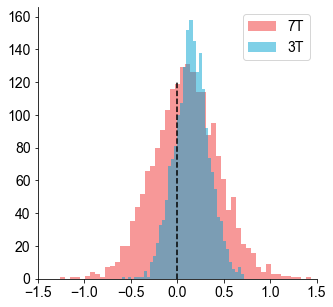

In [401]:
plt.figure(figsize=(5,5))
plt.hist(dist_7t, alpha=0.5,bins=50)
plt.hist(dist_3t,alpha=0.5, bins=40)
plt.legend(['7T','3T'])
plt.xlim([-1.5,1.5])
plt.vlines(x=0, ymin=0, ymax=120, color='k', linestyle='--')
sns.despine()

In [573]:
l_seed_r_tle_3t_all = get_mask_connectivity(np.concatenate(df_seed_3t[df_seed_3t['Final_Lat']=='R']['RH Seed 3t harm'].values,axis=-1), right_pcc)
r_seed_r_tle_3t_all = get_mask_connectivity(np.concatenate(df_seed_3t[df_seed_3t['Final_Lat']=='R']['LH Seed 3t harm'].values,axis=-1), right_pcc)

l_seed_l_tle_3t_all = get_mask_connectivity(np.concatenate(df_seed_3t[df_seed_3t['Final_Lat']=='L']['RH Seed 3t harm'].values,axis=-1), left_pcc)
r_seed_l_tle_3t_all = get_mask_connectivity(np.concatenate(df_seed_3t[df_seed_3t['Final_Lat']=='L']['LH Seed 3t harm'].values,axis=-1), left_pcc)


In [574]:
bootstrap_t_test(l_seed_l_tle_3t_all,r_seed_l_tle_3t_all, direction='less')
bootstrap_t_test(l_seed_r_tle_3t_all,r_seed_r_tle_3t_all, direction='greater')

The p-value is  0.0295
The p-value is  0.1082


Calculate Cohen's D for the 7T, 3T and 3T-all in order to see whether the 7T has a larger effect size

In [575]:
def cohend(d1, d2):
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
	# calculate the pooled standard deviation
	s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = np.mean(d1), np.mean(d2)
	# calculate the effect size
	return (u1 - u2) / s


In [576]:
l_tle_3t_all_cohend = cohend(l_seed_l_tle_3t_all,r_seed_l_tle_3t_all)
r_tle_3t_all_cohend = cohend(l_seed_r_tle_3t_all,r_seed_r_tle_3t_all)

l_tle_3t_cohend = cohend(l_seed_l_tle_3t,r_seed_l_tle_3t)
r_tle_3t_cohend = cohend(l_seed_r_tle_3t,r_seed_r_tle_3t)

l_tle_7t_cohend = cohend(l_seed_l_tle_7t,r_seed_l_tle_7t)
r_tle_7t_cohend = cohend(l_seed_r_tle_7t,r_seed_r_tle_7t)

Text(0, 0.5, "Cohen's D")

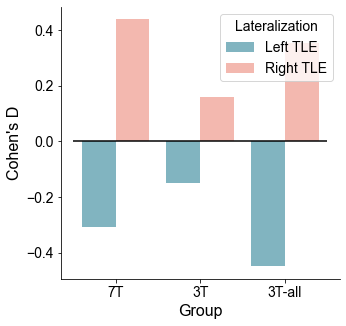

In [577]:
df_plot_cohend = pd.DataFrame()
df_plot_cohend['Cohen D'] = np.hstack([l_tle_3t_all_cohend, r_tle_3t_all_cohend, l_tle_3t_cohend, r_tle_3t_cohend, l_tle_7t_cohend, r_tle_7t_cohend,])
df_plot_cohend['Group'] = ['3T-all']*len(np.hstack([l_tle_3t_all_cohend, r_tle_3t_all_cohend])) + ['3T']*len(np.hstack([l_tle_3t_cohend, r_tle_3t_cohend])) + ['7T']*len(np.hstack([l_tle_7t_cohend, r_tle_7t_cohend]))
df_plot_cohend['Lateralization'] = ['Left TLE', 'Right TLE', 'Left TLE', 'Right TLE', 'Left TLE', 'Right TLE']

plt.figure(figsize=(5,5))
sns.barplot(x='Group', y='Cohen D', hue='Lateralization', order=['7T','3T','3T-all'],data=df_plot_cohend)
plt.hlines(y=0, xmin=-0.5, xmax=2.5, color='k')
sns.despine()
plt.ylabel('Cohen\'s D')
#plt.savefig('/Users/allucas/Documents/research/CNT/P18_7T_rsfMRI/output/figures/paper_figures/cohensd_pcc_value.pdf')

## Naive Classifier
This section creates a naive classifier that uses the value of the difference between left-right in order to classify the two lateralizations


In [616]:
# For the naive classifier, left PCC goes to left seed, right PCC goes to right seed

l_seed_r_tle_3t_all = get_mask_connectivity(np.concatenate(df_seed_3t[df_seed_3t['Final_Lat']=='R']['RH Seed 3t harm'].values,axis=-1), right_pcc)
r_seed_r_tle_3t_all = get_mask_connectivity(np.concatenate(df_seed_3t[df_seed_3t['Final_Lat']=='R']['LH Seed 3t harm'].values,axis=-1), left_pcc)

l_seed_l_tle_3t_all = get_mask_connectivity(np.concatenate(df_seed_3t[df_seed_3t['Final_Lat']=='L']['RH Seed 3t harm'].values,axis=-1), right_pcc)
r_seed_l_tle_3t_all = get_mask_connectivity(np.concatenate(df_seed_3t[df_seed_3t['Final_Lat']=='L']['LH Seed 3t harm'].values,axis=-1), left_pcc)

l_seed_l_tle_7t = get_mask_connectivity(np.concatenate(df_seed_all[df_seed_all['Lateralization']=='Left']['RH Seed harm'].values,axis=-1), right_pcc)
r_seed_l_tle_7t = get_mask_connectivity(np.concatenate(df_seed_all[df_seed_all['Lateralization']=='Left']['LH Seed harm'].values,axis=-1), left_pcc)

l_seed_l_tle_3t = get_mask_connectivity(np.concatenate(df_seed_all[df_seed_all['Lateralization']=='Left']['RH Seed 3t harm'].values,axis=-1), right_pcc)
r_seed_l_tle_3t = get_mask_connectivity(np.concatenate(df_seed_all[df_seed_all['Lateralization']=='Left']['LH Seed 3t harm'].values,axis=-1), left_pcc)

l_seed_r_tle_7t = get_mask_connectivity(np.concatenate(df_seed_all[df_seed_all['Lateralization']=='Right']['RH Seed harm'].values,axis=-1), right_pcc)
r_seed_r_tle_7t = get_mask_connectivity(np.concatenate(df_seed_all[df_seed_all['Lateralization']=='Right']['LH Seed harm'].values,axis=-1), left_pcc)

l_seed_r_tle_3t = get_mask_connectivity(np.concatenate(df_seed_all[df_seed_all['Lateralization']=='Right']['RH Seed 3t harm'].values,axis=-1), right_pcc)
r_seed_r_tle_3t = get_mask_connectivity(np.concatenate(df_seed_all[df_seed_all['Lateralization']=='Right']['LH Seed 3t harm'].values,axis=-1), left_pcc)


In [617]:

# 7T
X = np.hstack((l_seed_l_tle_7t, l_seed_r_tle_7t)) - np.hstack((r_seed_l_tle_7t, r_seed_r_tle_7t))
y = np.array(['L']*len(l_seed_l_tle_7t) + ['R']*len(l_seed_r_tle_7t), object)

fpr_7t, tpr_7t, _ = roc_curve(y=='R', X)

# 3T
X = np.hstack((l_seed_l_tle_3t, l_seed_r_tle_3t)) - np.hstack((r_seed_l_tle_3t, r_seed_r_tle_3t))
y = np.array(['L']*len(l_seed_l_tle_3t) + ['R']*len(l_seed_r_tle_3t), object)

fpr_3t, tpr_3t, _ = roc_curve(y=='R', X)

# 3T-all
X = np.hstack((l_seed_l_tle_3t_all, l_seed_r_tle_3t_all)) - np.hstack((r_seed_l_tle_3t_all, r_seed_r_tle_3t_all))
y = np.array(['L']*len(l_seed_l_tle_3t_all) + ['R']*len(l_seed_r_tle_3t_all), object)

fpr_3t_all, tpr_3t_all, _ = roc_curve(y=='R', X)

In [618]:
# # For the naive classifier, left PCC goes to left seed, right PCC goes to right seed

# l_seed_r_tle_3t_all = get_mask_connectivity(np.concatenate(df_seed_3t[df_seed_3t['Final_Lat']=='R']['RH Seed 3t harm'].values,axis=-1), right_pcc)
# r_seed_r_tle_3t_all = get_mask_connectivity(np.concatenate(df_seed_3t[df_seed_3t['Final_Lat']=='R']['LH Seed 3t harm'].values,axis=-1), left_pcc)

# l_seed_l_tle_3t_all = get_mask_connectivity(np.concatenate(df_seed_3t[df_seed_3t['Final_Lat']=='L']['RH Seed 3t harm'].values,axis=-1), right_pcc)
# r_seed_l_tle_3t_all = get_mask_connectivity(np.concatenate(df_seed_3t[df_seed_3t['Final_Lat']=='L']['LH Seed 3t harm'].values,axis=-1), left_pcc)


# l_seed_l_tle_7t = get_mask_connectivity(np.concatenate(df_seed_all[df_seed_all['Lateralization']=='Left']['RH Seed harm'].values,axis=-1), right_pcc)
# r_seed_l_tle_7t = get_mask_connectivity(np.concatenate(df_seed_all[df_seed_all['Lateralization']=='Left']['LH Seed harm'].values,axis=-1), left_pcc)

# l_seed_l_tle_3t = get_mask_connectivity(np.concatenate(df_seed_all[df_seed_all['Lateralization']=='Left']['RH Seed 3t harm'].values,axis=-1), right_pcc)
# r_seed_l_tle_3t = get_mask_connectivity(np.concatenate(df_seed_all[df_seed_all['Lateralization']=='Left']['LH Seed 3t harm'].values,axis=-1), left_pcc)

# l_seed_r_tle_7t = get_mask_connectivity(np.concatenate(df_seed_all[df_seed_all['Lateralization']=='Right']['RH Seed harm'].values,axis=-1), right_pcc)
# r_seed_r_tle_7t = get_mask_connectivity(np.concatenate(df_seed_all[df_seed_all['Lateralization']=='Right']['LH Seed harm'].values,axis=-1), left_pcc)

# l_seed_r_tle_3t = get_mask_connectivity(np.concatenate(df_seed_all[df_seed_all['Lateralization']=='Right']['RH Seed 3t harm'].values,axis=-1), right_pcc)
# r_seed_r_tle_3t = get_mask_connectivity(np.concatenate(df_seed_all[df_seed_all['Lateralization']=='Right']['LH Seed 3t harm'].values,axis=-1), left_pcc)


# # 7T
# X = df_plot_7t[df_plot_7t['Seed']=='Left Seed']['Mean ROI'].values - df_plot_7t[df_plot_7t['Seed']=='Right Seed']['Mean ROI'].values
# y = df_plot_7t[df_plot_7t['Seed']=='Left Seed']['Lateralization'].values

# fpr_7t, tpr_7t, _ = roc_curve(y=='Right TLE', X)

# # 7T
# X = df_plot_3t[df_plot_3t['Seed']=='Left Seed']['Mean ROI'].values - df_plot_3t[df_plot_3t['Seed']=='Right Seed']['Mean ROI'].values
# y = df_plot_3t[df_plot_3t['Seed']=='Left Seed']['Lateralization'].values

# fpr_3t, tpr_3t, _ = roc_curve(y=='Right TLE', X)

# # 3T-all
# X = df_plot_3t_all[df_plot_3t_all['Seed']=='Left Seed']['Mean ROI'].values - df_plot_3t_all[df_plot_3t_all['Seed']=='Right Seed']['Mean ROI'].values
# y = df_plot_3t_all[df_plot_3t_all['Seed']=='Left Seed']['Lateralization'].values

# fpr_3t_all, tpr_3t_all, _ = roc_curve(y=='Right TLE', X)

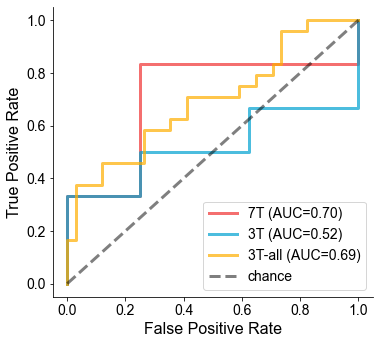

In [620]:
# ROC Curves

colors = ["#f03232","#00a2d0","#feae00","#acacac"]
sns.set_palette(sns.color_palette(colors))

# Plot the ROC
plt.figure(figsize=(5.5,5))
plt.plot(fpr_7t,tpr_7t, linewidth=3, alpha=0.7)
plt.plot(fpr_3t,tpr_3t, linewidth=3, alpha=0.7)
plt.plot(fpr_3t_all,tpr_3t_all, linewidth=3, alpha=0.7)

plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1),'--', linewidth=3, color='k', alpha=0.5)
sns.despine()
plt.legend(['7T (AUC='+str(auc(fpr_7t,tpr_7t))[:4]+')','3T (AUC='+str(auc(fpr_3t,tpr_3t))[:4]+')','3T-all (AUC='+str(auc(fpr_3t_all,tpr_3t_all))[:4]+')','chance'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


plt.tight_layout()
#plt.savefig('/Users/allucas/Documents/research/CNT/P18_7T_rsfMRI/output/figures/paper_figures/updated_figures/naive_roc.pdf')

## PCA of Seed-Maps for Separating Left and Right TLE

### PCA

In [621]:
from sklearn.metrics import roc_curve, auc

colors = ["#76BACB","#FFAFA3","#acacac","#feae00"]
sns.set_palette(colors)


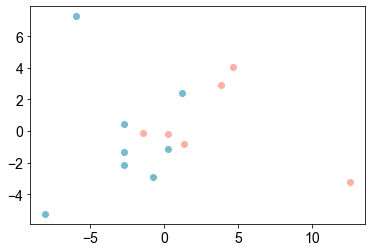

In [622]:
# X = []
# y = []
# for i in range(len(df_seed_all)):
#     if df_seed_all.iloc[i]['Lateralization']=='Left':
#         y.append(1)
#         X.append(zero_nan(df_seed_all.iloc[i]['LH Seed harm'][:,:,:,0]*left_pcc).ravel())
#     elif df_seed_all.iloc[i]['Lateralization']=='Right':
#         y.append(2)
#         X.append(zero_nan(df_seed_all.iloc[i]['LH Seed harm'][:,:,:,0]*left_pcc).ravel())
  
# X = np.vstack(X)
# y = np.array(y)
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# X_embedded = pca.fit_transform(X)
# X_embedded.shape
# plt.figure(figsize=[3,3])
# plt.scatter(X_embedded[y==1,0], X_embedded[y==1,1], s=50)
# plt.scatter(X_embedded[y==2,0], X_embedded[y==2,1],s=50)
# plt.scatter(X_embedded[y==0,0], X_embedded[y==0,1])
# sns.despine()
# plt.xlabel('PC1')
# plt.ylabel('PC2')


# fpr_7t, tpr_7t, _ = roc_curve(y==1, X_embedded[:,0])
#plt.legend(['Control','MTL','non-MTL'])

# Inlcuding left and right seeds
X = []
y = []
for i in range(len(df_seed_all)):
    if df_seed_all.iloc[i]['Lateralization']=='Left':
        y.append(1)
        X.append(np.hstack([zero_nan((df_seed_all.iloc[i]['LH Seed harm'][:,:,:,0]-df_seed_all.iloc[i]['RH Seed harm'][:,:,:,0])*right_pcc).ravel(), zero_nan((df_seed_all.iloc[i]['LH Seed harm'][:,:,:,0]-df_seed_all.iloc[i]['RH Seed harm'][:,:,:,0])*left_pcc).ravel()]))
    elif df_seed_all.iloc[i]['Lateralization']=='Right':
        y.append(2)
        X.append(np.hstack([zero_nan((df_seed_all.iloc[i]['LH Seed harm'][:,:,:,0]-df_seed_all.iloc[i]['RH Seed harm'][:,:,:,0])*right_pcc).ravel(), zero_nan((df_seed_all.iloc[i]['LH Seed harm'][:,:,:,0]-df_seed_all.iloc[i]['RH Seed harm'][:,:,:,0])*left_pcc).ravel()]))
  
X = np.vstack(X)
y = np.array(y)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_embedded = pca.fit_transform(X)
X_embedded.shape
plt.scatter(X_embedded[y==1,0], X_embedded[y==1,1])
plt.scatter(X_embedded[y==2,0], X_embedded[y==2,1])
plt.scatter(X_embedded[y==0,0], X_embedded[y==0,1])
#plt.legend(['Left TLE','Right TLE'])
fpr_7t, tpr_7t, _ = roc_curve(y==2, X_embedded[:,0])


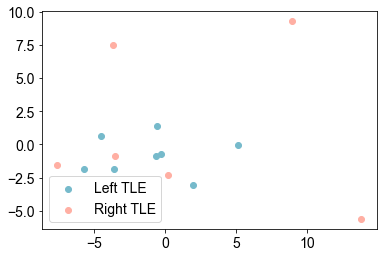

In [623]:
# X = []
# y = []
# for i in range(len(df_seed_all)):
#     if df_seed_all.iloc[i]['Lateralization']=='Left':
#         y.append(1)
#         X.append(zero_nan(df_seed_all.iloc[i]['LH Seed 3t harm'][:,:,:,0]*left_pcc).ravel())
#     elif df_seed_all.iloc[i]['Lateralization']=='Right':
#         y.append(2)
#         X.append(zero_nan(df_seed_all.iloc[i]['LH Seed 3t harm'][:,:,:,0]*left_pcc).ravel())
  
# X = np.vstack(X)
# y = np.array(y)
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# X_embedded = pca.fit_transform(X)
# X_embedded.shape
# plt.figure(figsize=[3,3])
# plt.scatter(X_embedded[y==1,0], X_embedded[y==1,1], s=50)
# plt.scatter(X_embedded[y==2,0], X_embedded[y==2,1],s=50)
# plt.scatter(X_embedded[y==0,0], X_embedded[y==0,1])
# sns.despine()
# plt.xlabel('PC1')
# plt.ylabel('PC2')


# fpr_3t, tpr_3t, _ = roc_curve(y==1, X_embedded[:,0])
# plt.legend(['Left TLE','Right TLE'])


X = []
y = []
for i in range(len(df_seed_all)):
    if df_seed_all.iloc[i]['Lateralization']=='Left':
        y.append(1)
        X.append(np.hstack([zero_nan((df_seed_all.iloc[i]['LH Seed 3t harm'][:,:,:,0]-df_seed_all.iloc[i]['RH Seed 3t harm'][:,:,:,0])*right_pcc).ravel(), zero_nan((df_seed_all.iloc[i]['LH Seed 3t harm'][:,:,:,0]-df_seed_all.iloc[i]['RH Seed 3t harm'][:,:,:,0])*left_pcc).ravel()]))
    elif df_seed_all.iloc[i]['Lateralization']=='Right':
        y.append(2)
        X.append(np.hstack([zero_nan((df_seed_all.iloc[i]['LH Seed 3t harm'][:,:,:,0]-df_seed_all.iloc[i]['RH Seed 3t harm'][:,:,:,0])*right_pcc).ravel(), zero_nan((df_seed_all.iloc[i]['LH Seed 3t harm'][:,:,:,0]-df_seed_all.iloc[i]['RH Seed 3t harm'][:,:,:,0])*left_pcc).ravel()]))
  
X = np.vstack(X)
y = np.array(y)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_embedded = pca.fit_transform(X)
X_embedded.shape
plt.scatter(X_embedded[y==1,0], X_embedded[y==1,1])
plt.scatter(X_embedded[y==2,0], X_embedded[y==2,1])
plt.scatter(X_embedded[y==0,0], X_embedded[y==0,1])
plt.legend(['Left TLE','Right TLE'])

fpr_3t, tpr_3t, _ = roc_curve(y==2, X_embedded[:,0])


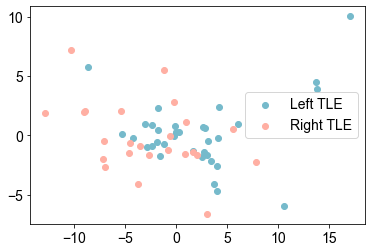

In [624]:
# X = []
# y = []
# for i in range(len(df_seed_3t)):
#     if df_seed_3t.iloc[i]['Final_Lat']=='L':
#         y.append(1)
#         X.append(zero_nan(df_seed_3t.iloc[i]['RH Seed 3t harm'][:,:,:,0]*right_pcc).ravel())
#     elif df_seed_3t.iloc[i]['Final_Lat']=='R':
#         y.append(2)
#         X.append(zero_nan(df_seed_3t.iloc[i]['RH Seed 3t harm'][:,:,:,0]*right_pcc).ravel())
  
# X = np.vstack(X)
# y = np.array(y)
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# X_embedded = pca.fit_transform(X)
# X_embedded.shape
# plt.figure(figsize=[ 3,3])
# plt.scatter(X_embedded[y==1,0], X_embedded[y==1,1], s=50)
# plt.scatter(X_embedded[y==2,0], X_embedded[y==2,1],s=50)
# plt.scatter(X_embedded[y==0,0], X_embedded[y==0,1])
# sns.despine()
# plt.xlabel('PC1')
# plt.ylabel('PC2')

# fpr_3t_all, tpr_3t_all, _ = roc_curve(y==1, X_embedded[:,0])



# Inlcuding left and right seeds
X = []
y = []
for i in range(len(df_seed_3t)):
    if df_seed_3t.iloc[i]['Final_Lat']=='L':
        y.append(1)
        X.append(np.hstack([zero_nan((df_seed_3t.iloc[i]['LH Seed 3t harm'][:,:,:,0]-df_seed_3t.iloc[i]['RH Seed 3t harm'][:,:,:,0])*right_pcc).ravel(), zero_nan((df_seed_3t.iloc[i]['LH Seed 3t harm'][:,:,:,0]-df_seed_3t.iloc[i]['RH Seed 3t harm'][:,:,:,0])*left_pcc).ravel()]))
    elif df_seed_3t.iloc[i]['Final_Lat']=='R':
        y.append(2)
        X.append(np.hstack([zero_nan((df_seed_3t.iloc[i]['LH Seed 3t harm'][:,:,:,0]-df_seed_3t.iloc[i]['RH Seed 3t harm'][:,:,:,0])*right_pcc).ravel(), zero_nan((df_seed_3t.iloc[i]['LH Seed 3t harm'][:,:,:,0]-df_seed_3t.iloc[i]['RH Seed 3t harm'][:,:,:,0])*left_pcc).ravel()]))
  
X = np.vstack(X)
y = np.array(y)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_embedded = pca.fit_transform(X)
X_embedded.shape
plt.scatter(X_embedded[y==1,0], X_embedded[y==1,1])
plt.scatter(X_embedded[y==2,0], X_embedded[y==2,1])
plt.scatter(X_embedded[y==0,0], X_embedded[y==0,1])
plt.legend(['Left TLE','Right TLE'])
fpr_3t_all, tpr_3t_all, _ = roc_curve(y==1, X_embedded[:,0])

In [625]:
fpr_3t_all, tpr_3t_all, _ = roc_curve(y==1, X_embedded[:,0])


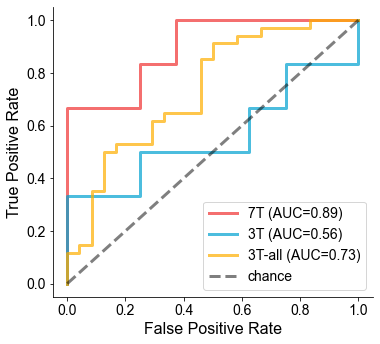

In [627]:
# ROC Curves

colors = ["#f03232","#00a2d0","#feae00","#acacac"]
sns.set_palette(sns.color_palette(colors))

# Plot the ROC
plt.figure(figsize=(5.5,5))
plt.plot(fpr_7t,tpr_7t, linewidth=3, alpha=0.7)
plt.plot(fpr_3t,tpr_3t, linewidth=3, alpha=0.7)
plt.plot(fpr_3t_all,tpr_3t_all, linewidth=3, alpha=0.7)

plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1),'--', linewidth=3, color='k', alpha=0.5)
sns.despine()
plt.legend(['7T (AUC='+str(auc(fpr_7t,tpr_7t))[:4]+')','3T (AUC='+str(auc(fpr_3t,tpr_3t))[:4]+')','3T-all (AUC='+str(auc(fpr_3t_all,tpr_3t_all))[:4]+')','chance'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


plt.tight_layout()
#plt.savefig('/Users/allucas/Documents/research/CNT/P18_7T_rsfMRI/output/figures/paper_figures/updated_figures/pca_roc.pdf')